### 초기 설정
라이브러리 불러오기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격 - 타겟 데이터
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    


In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

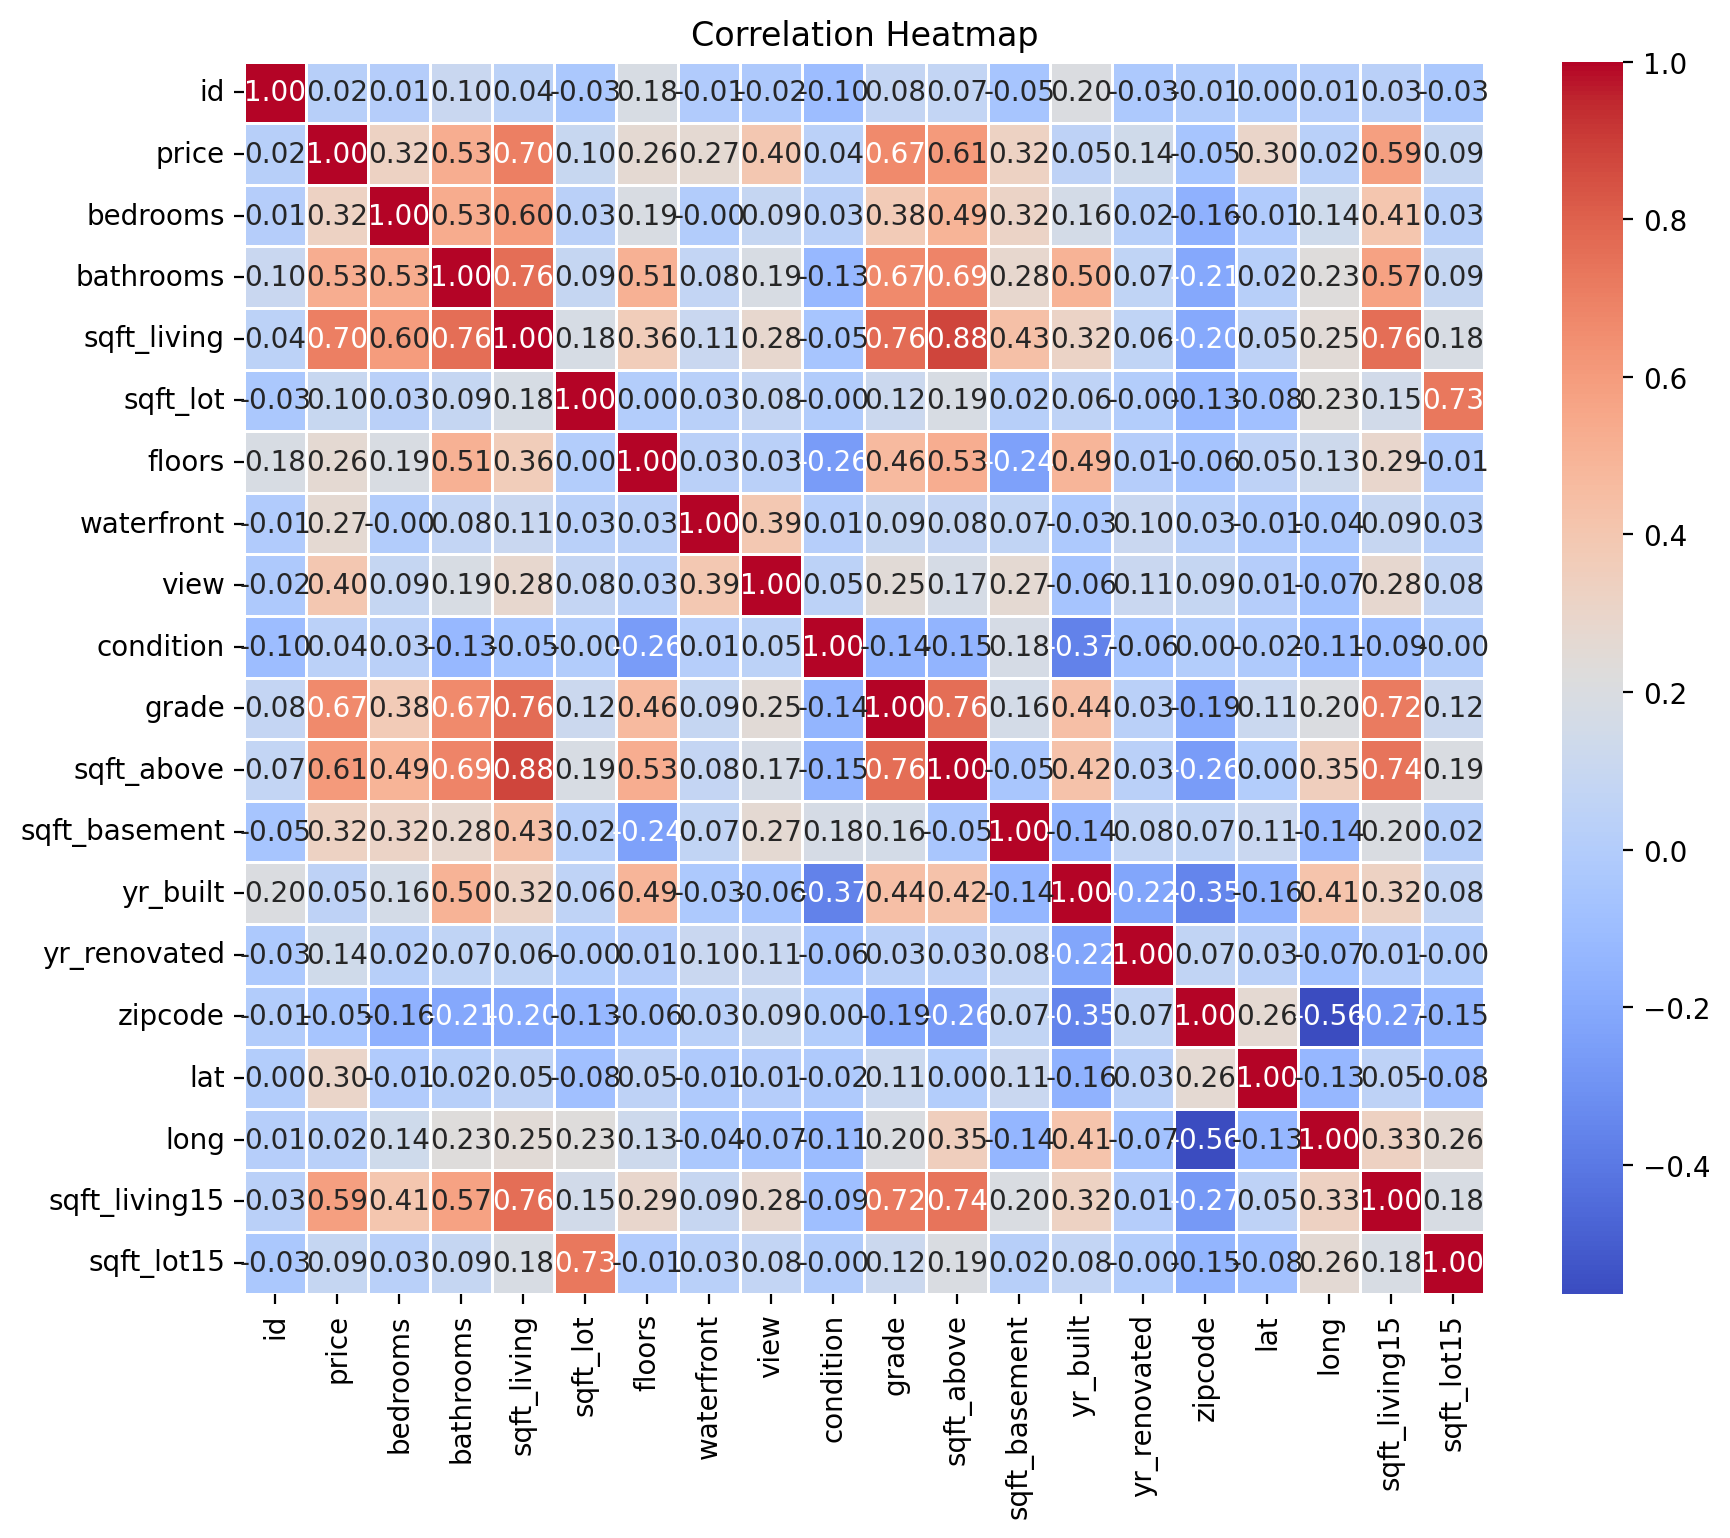

In [ ]:
# price 상관 계수 확인

# 수치형 데이터만 선택
numeric_data = train.select_dtypes(include=['number'])

# 상관 계수 계산
corr = numeric_data.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

view와 waterfront는 서로와 price를 제외하고는 약한 상관 관계를 가지고 있다. 왜 price와 상관 관계가 보일까?


### 주소 지정
train, test 데이터 불러오기

In [ ]:
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/data'

# train_data_path = join(data_dir, 'train.csv')
# test_data_path = join(data_dir, 'test.csv')

# train = pd.read_csv(train_data_path)
# test = pd.read_csv(test_data_path)

### train data 확인

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [ ]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

### train data 시각화

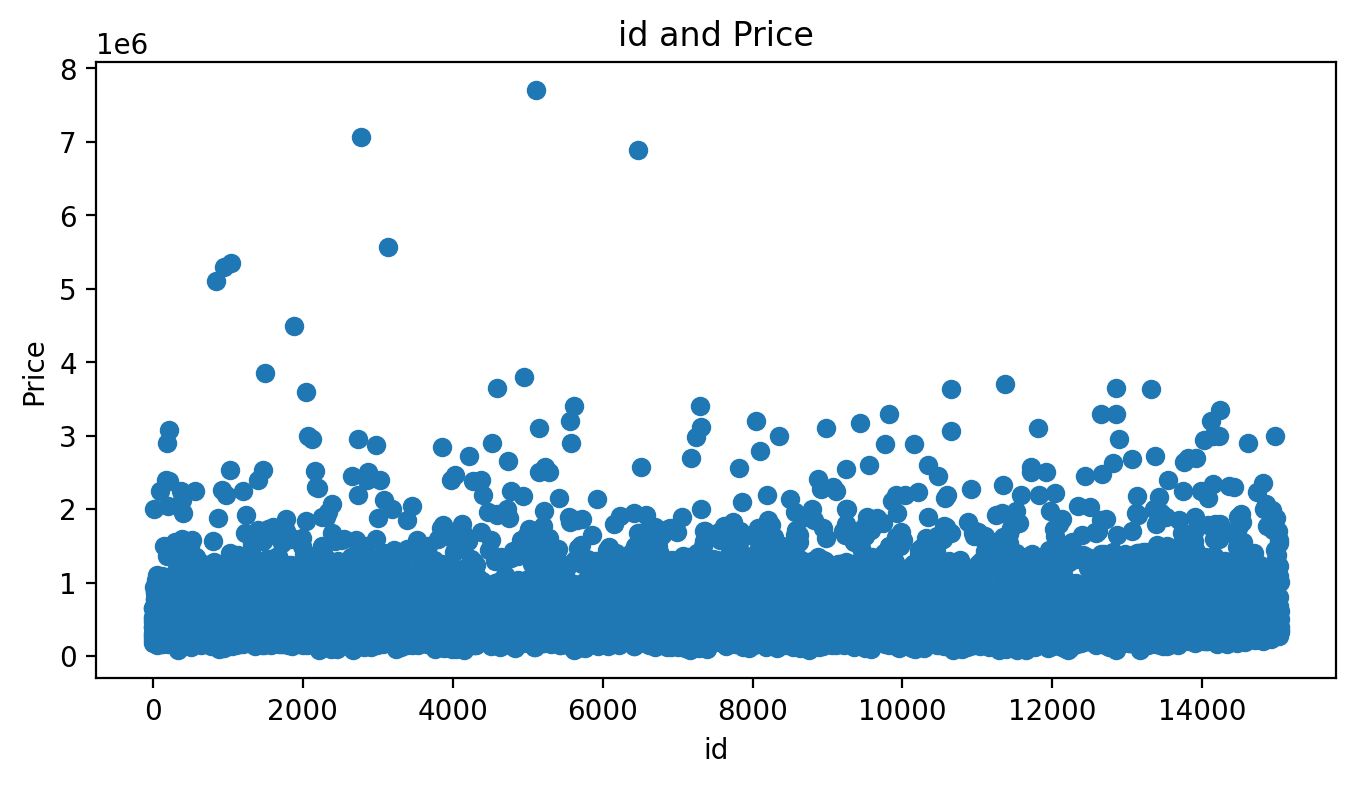

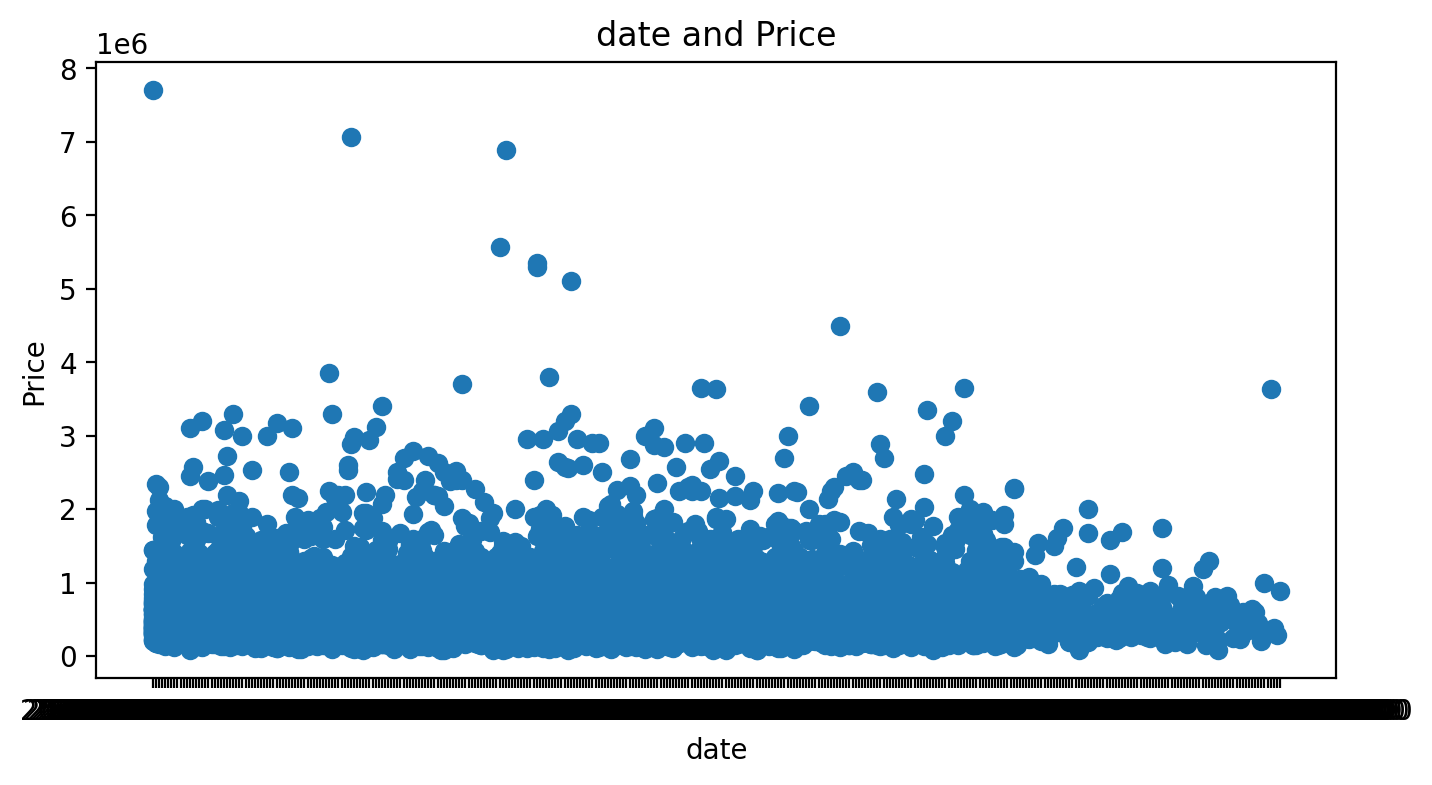

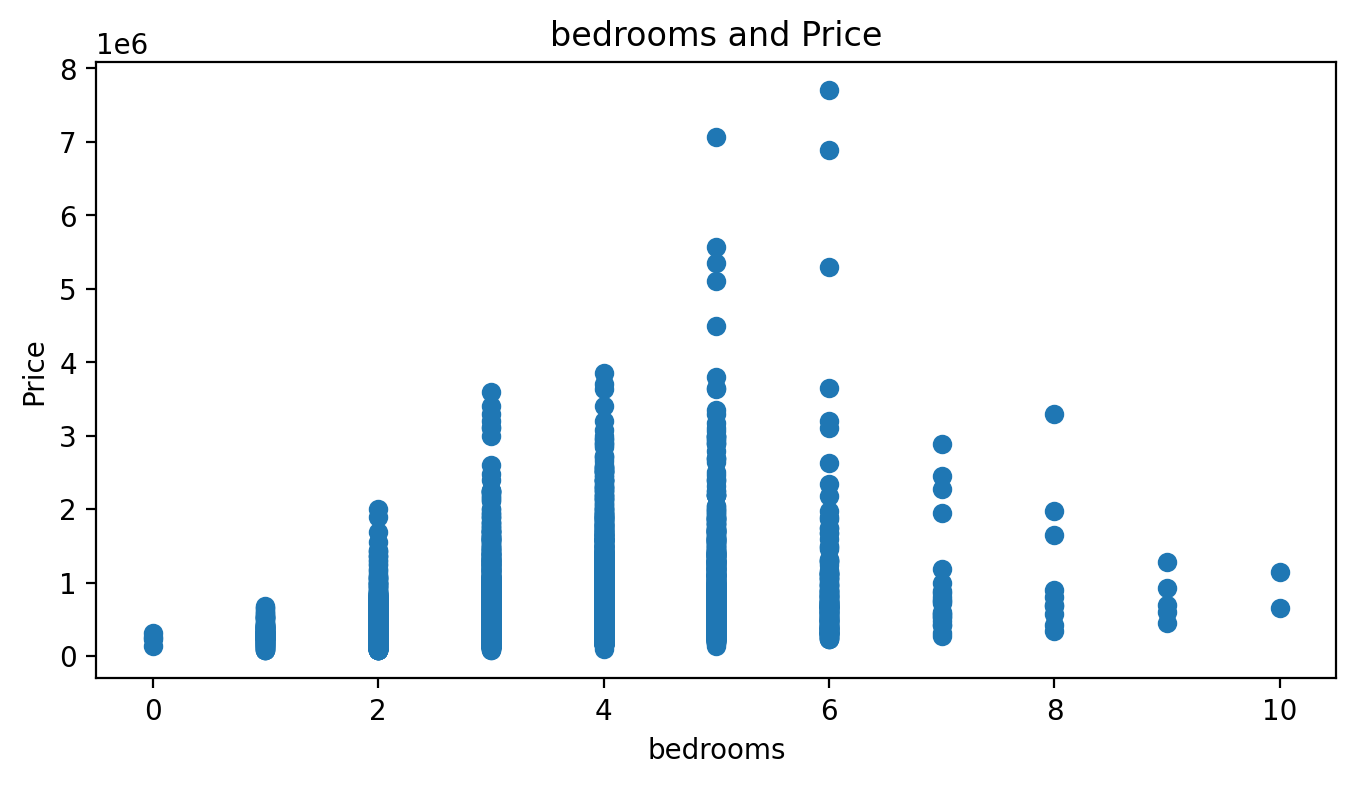

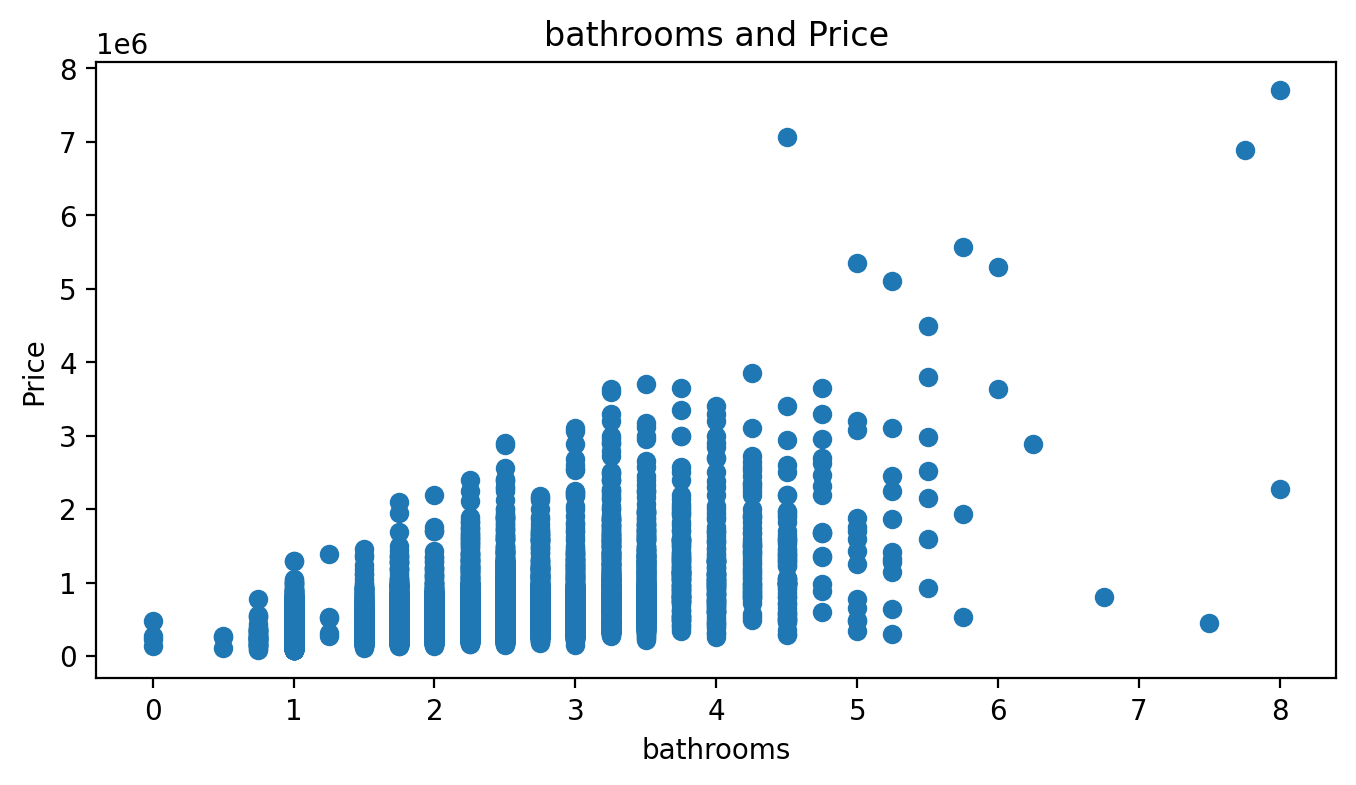

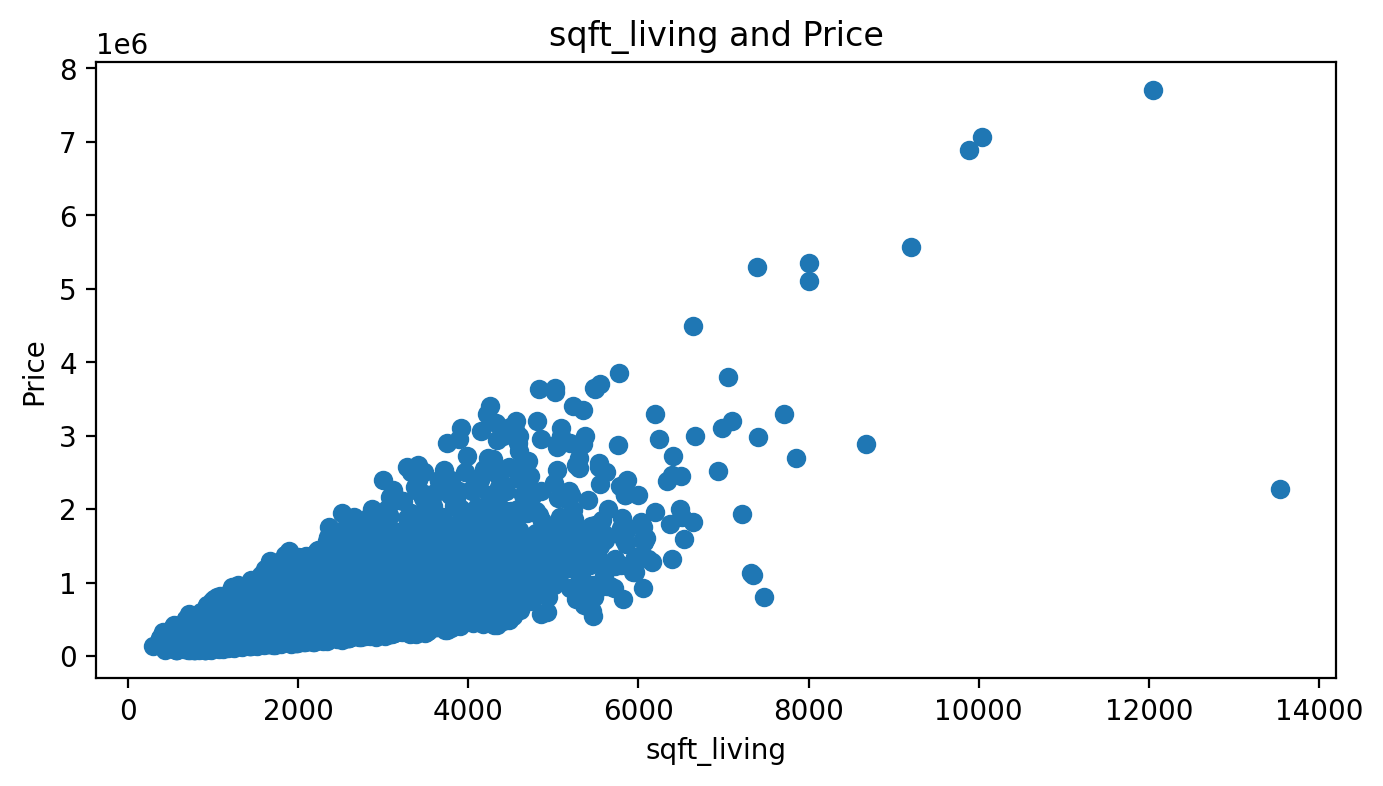

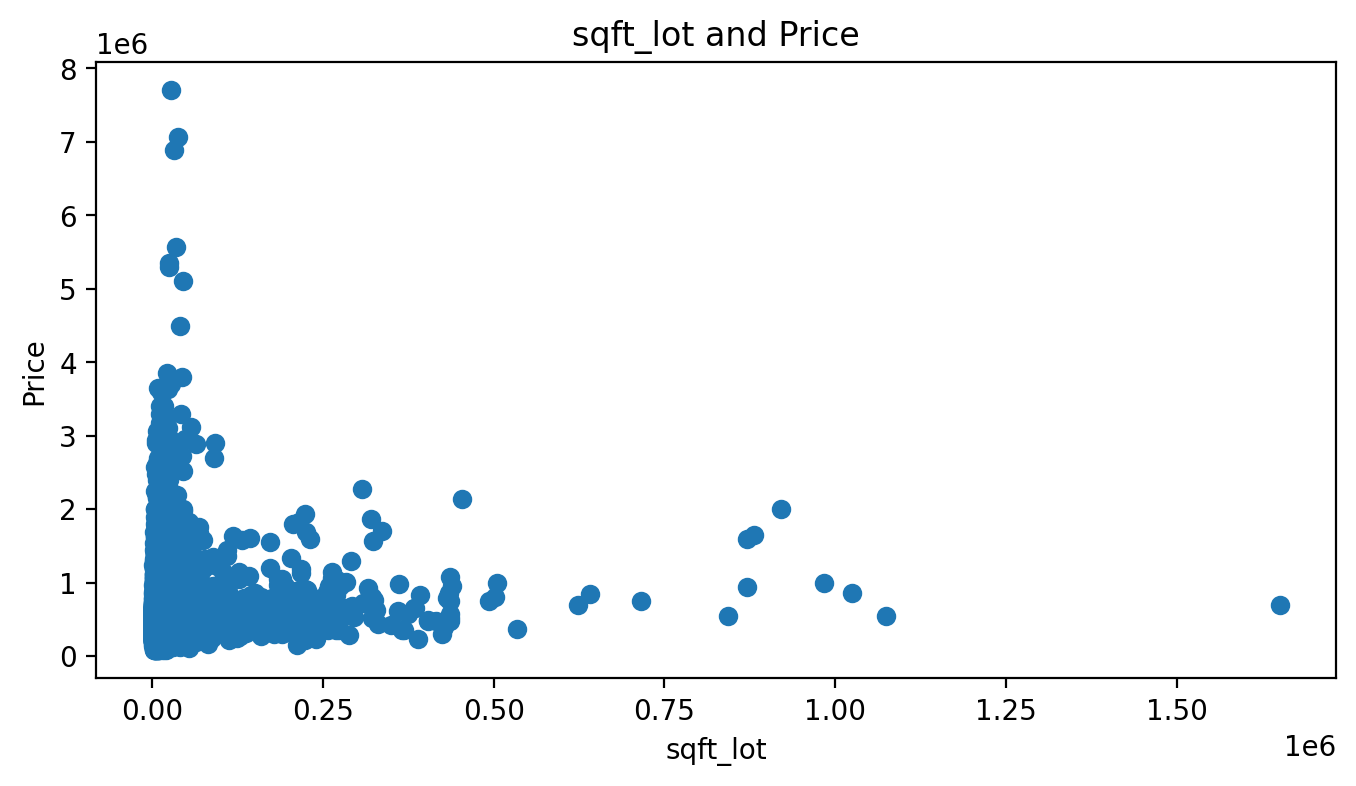

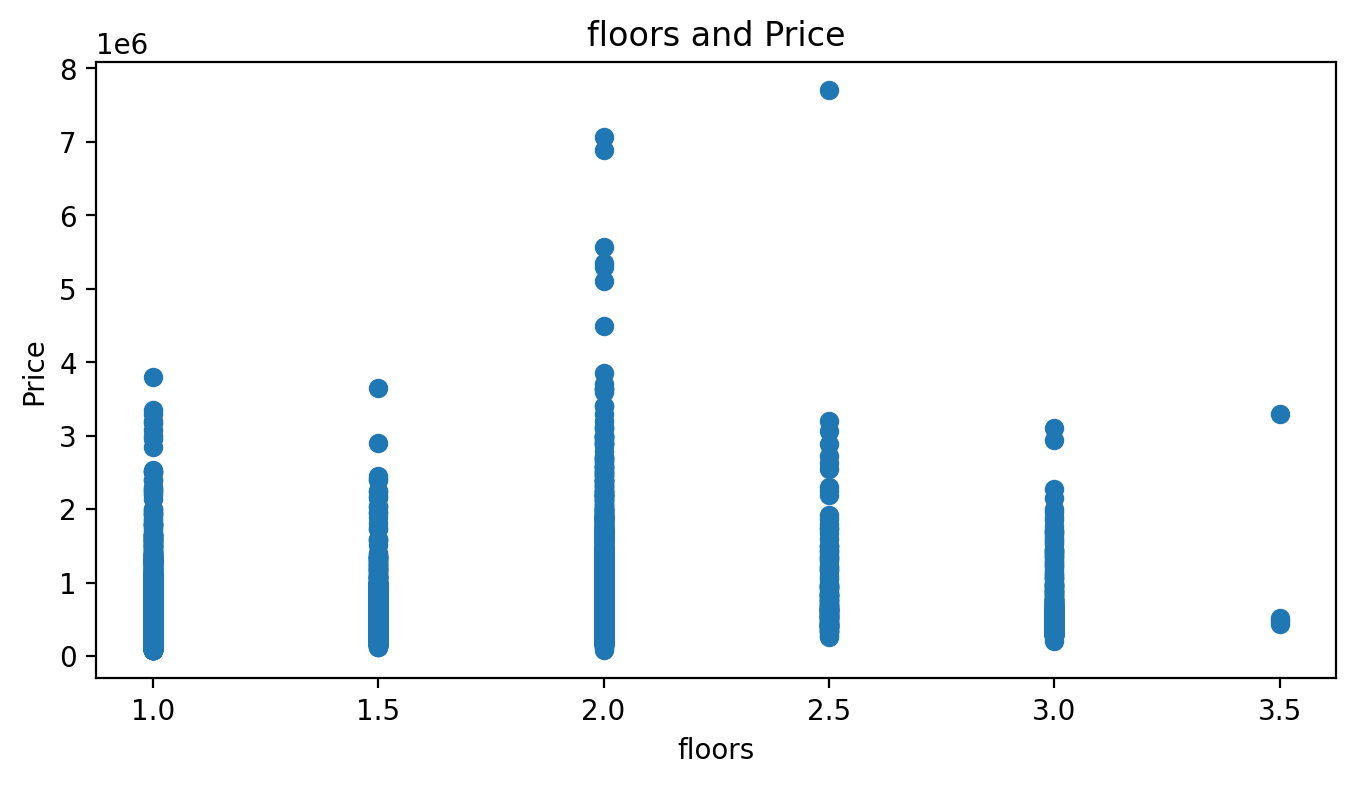

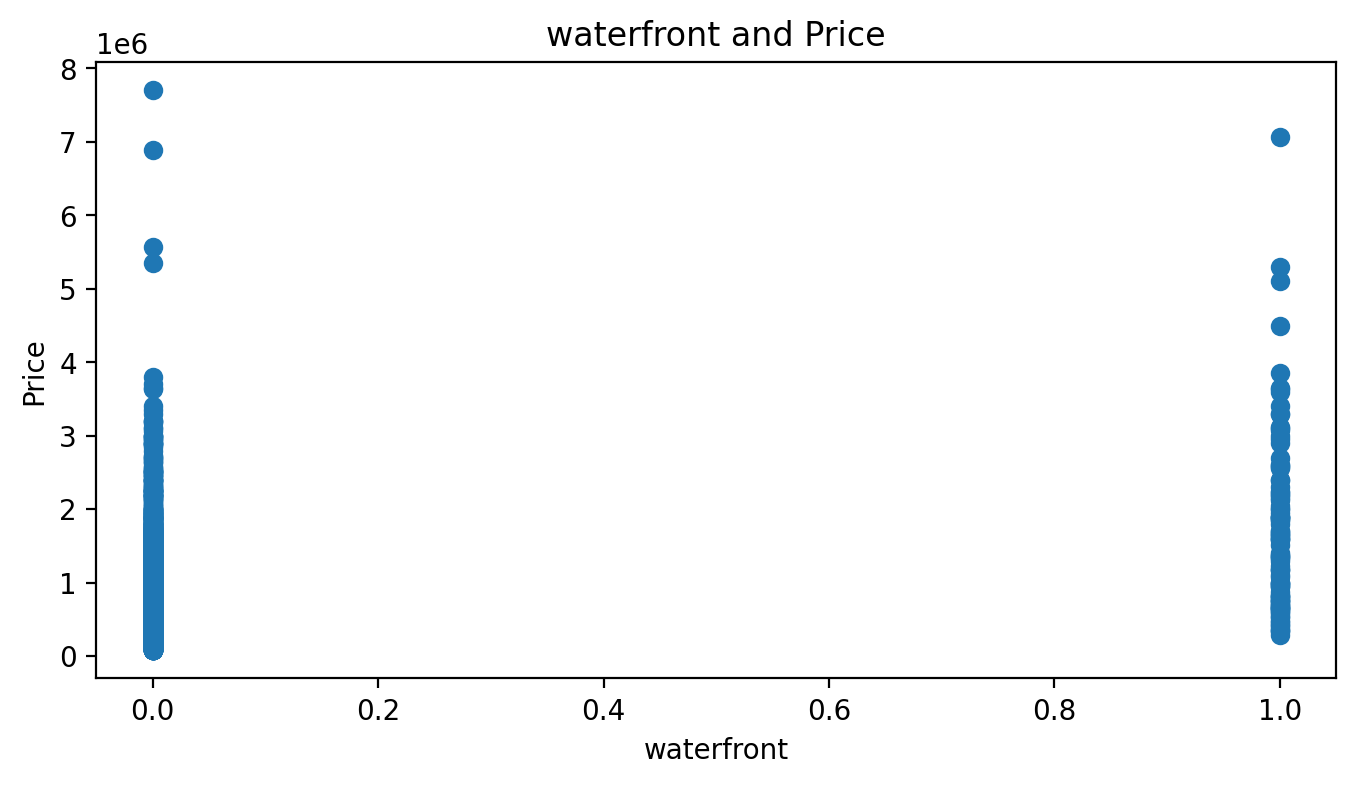

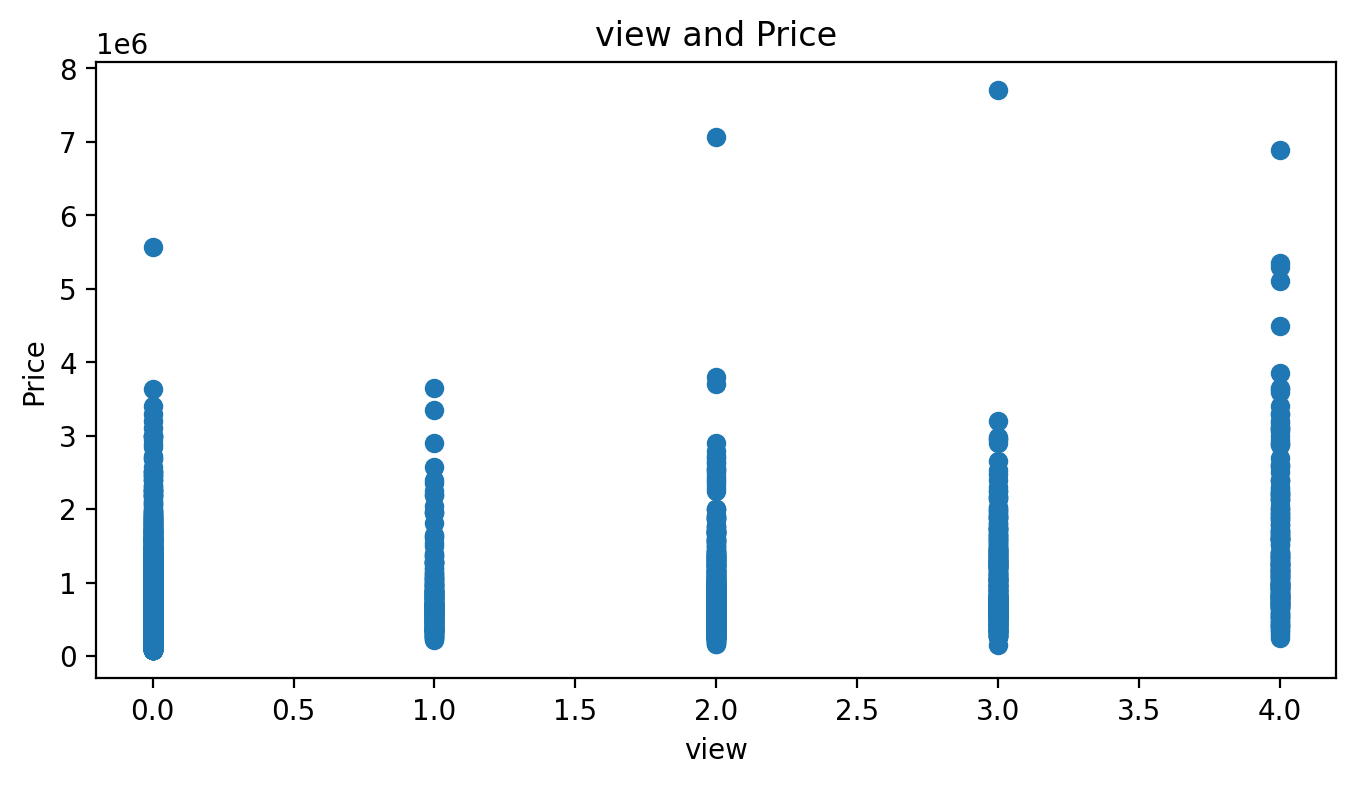

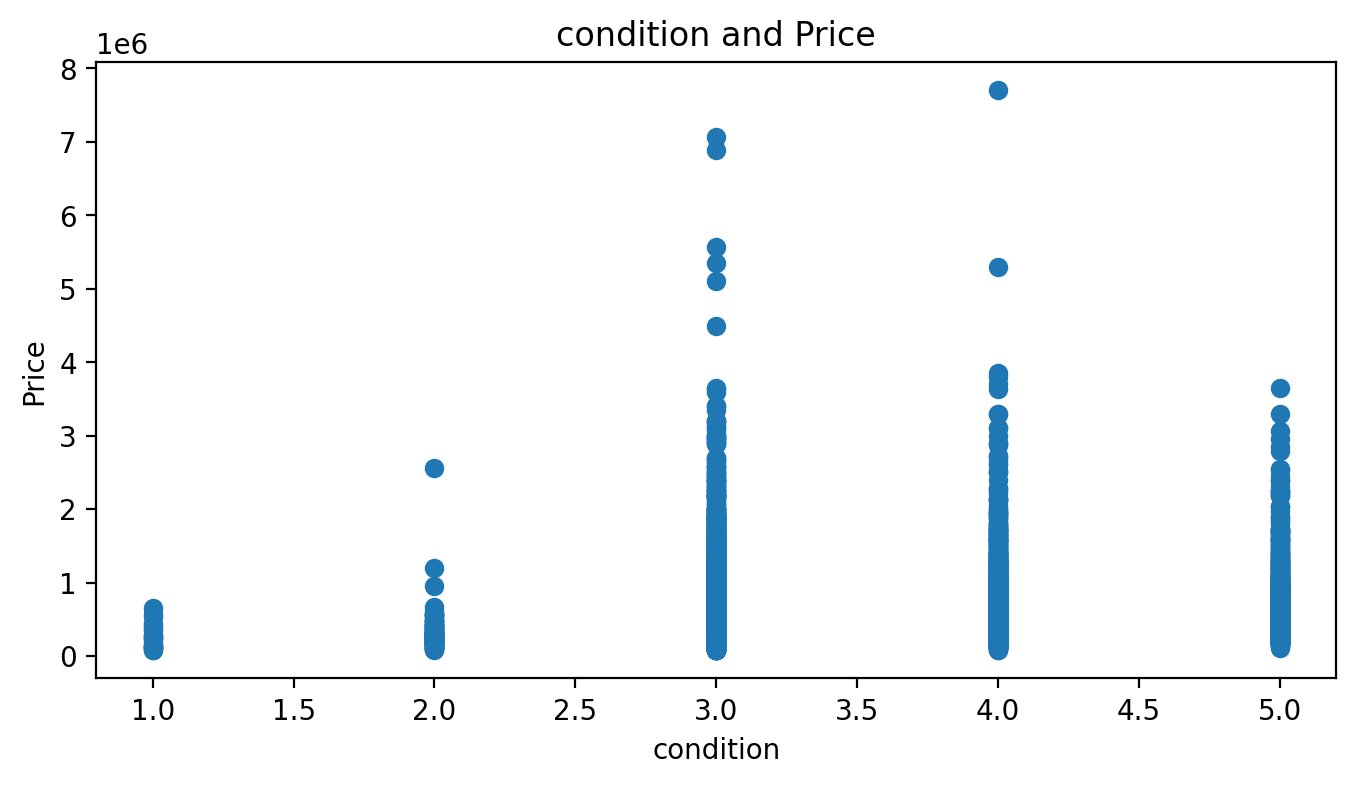

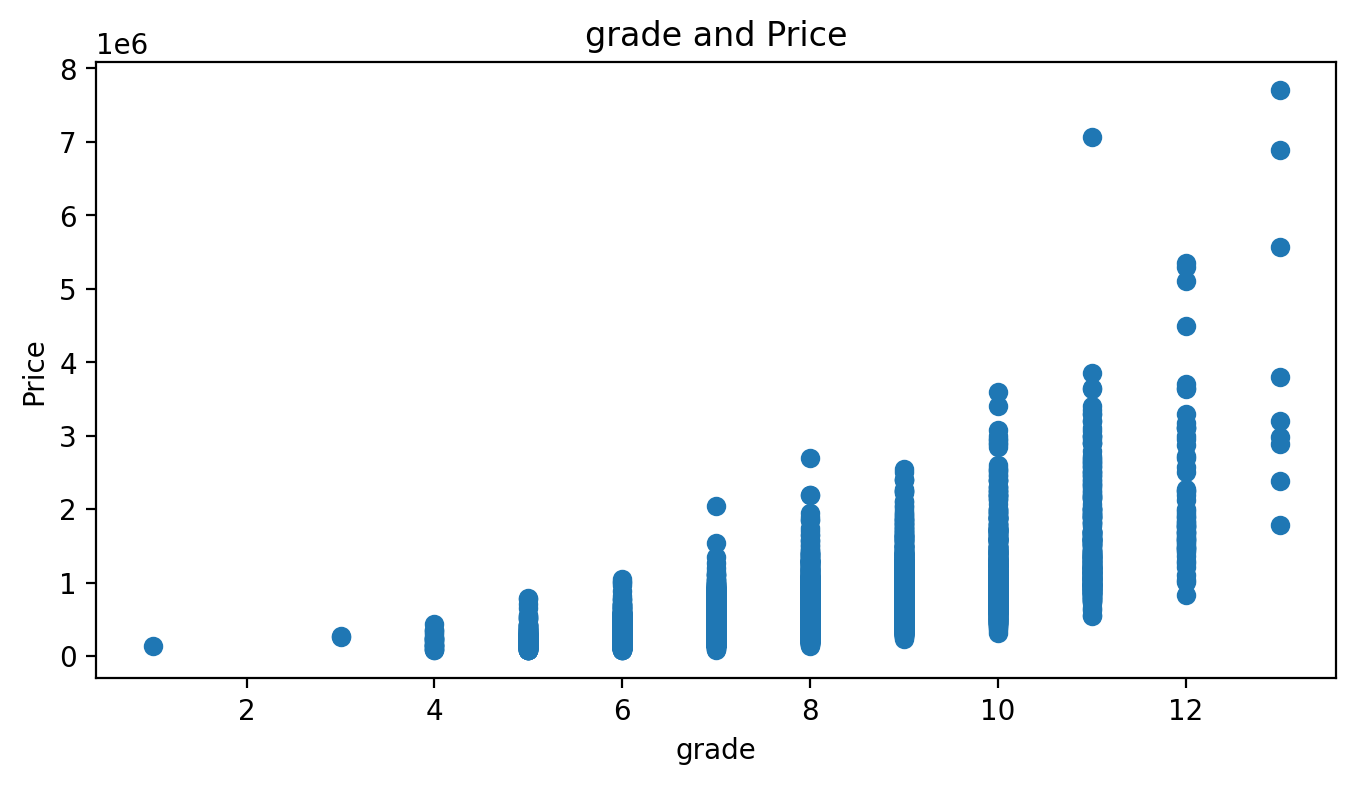

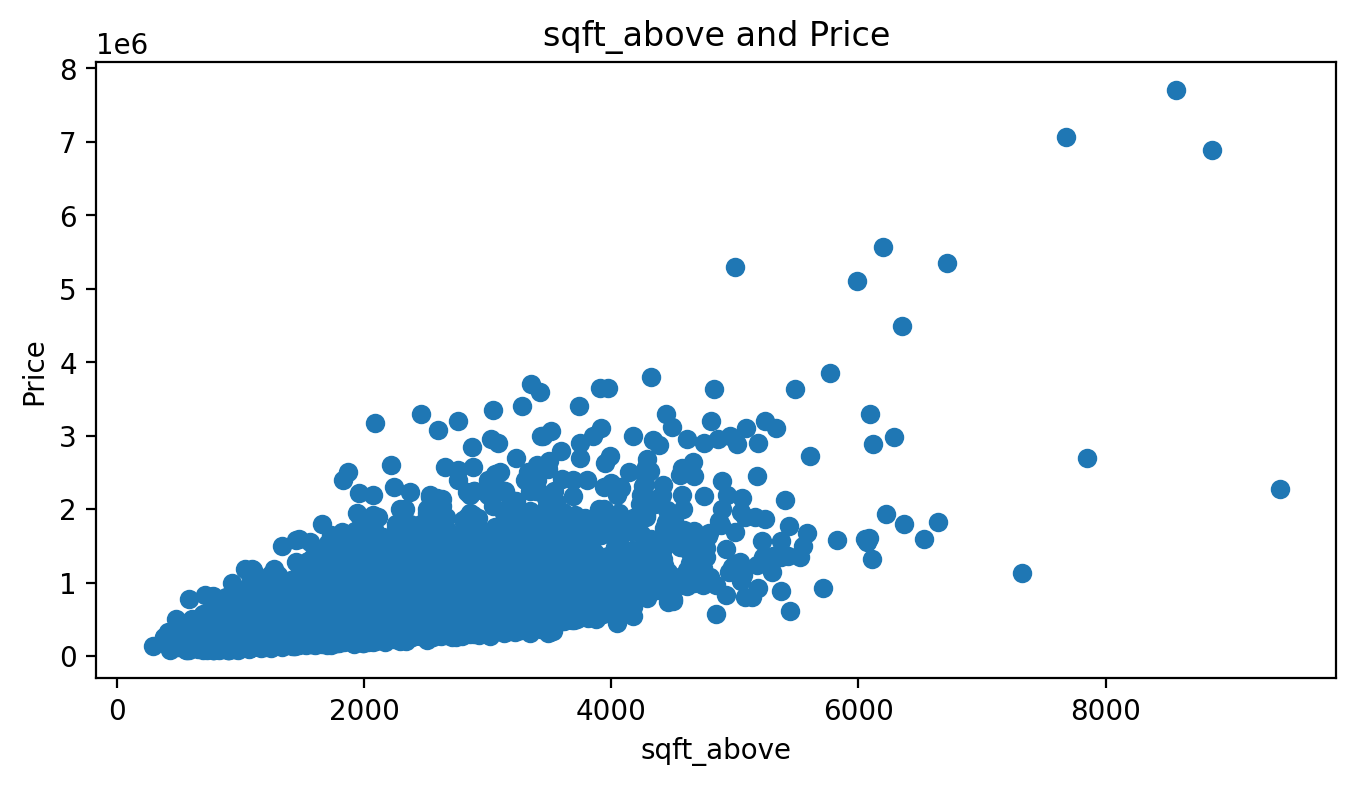

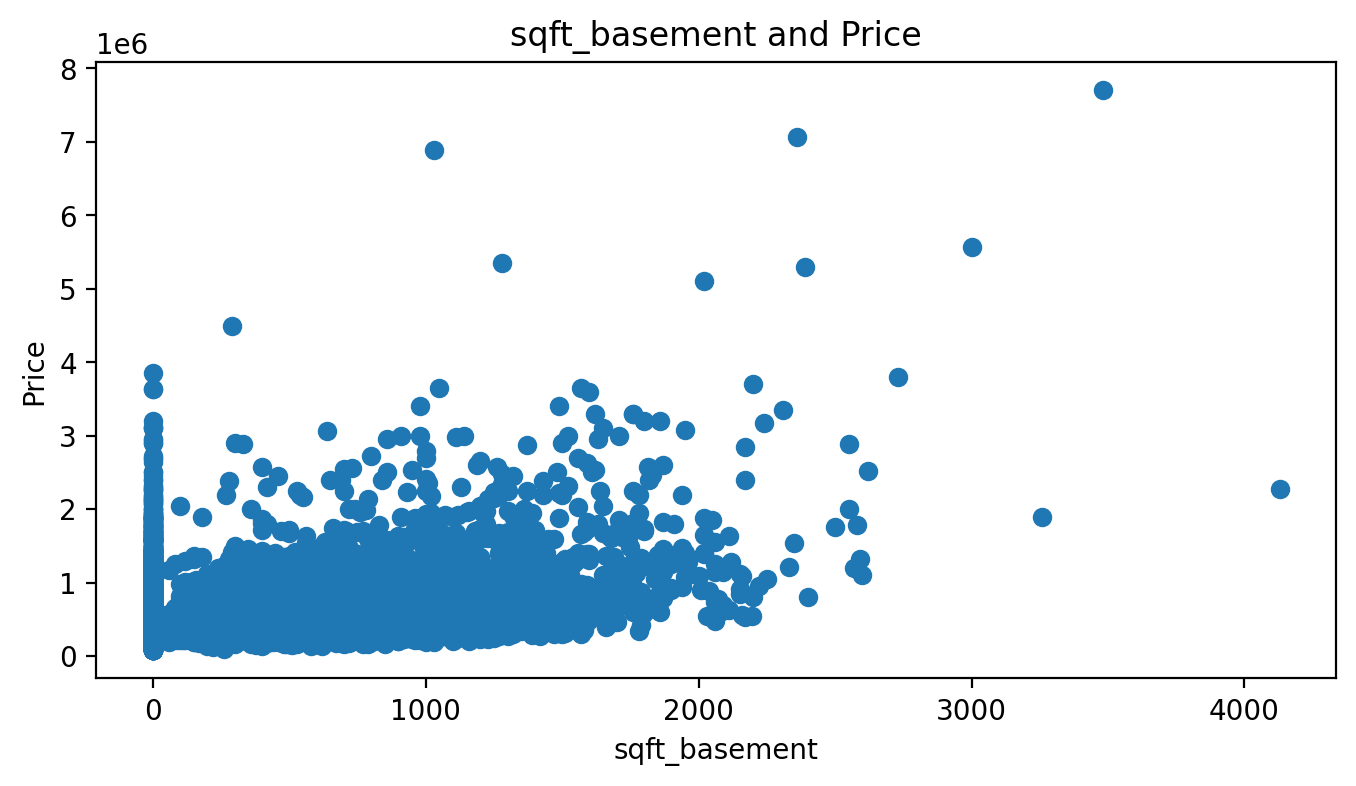

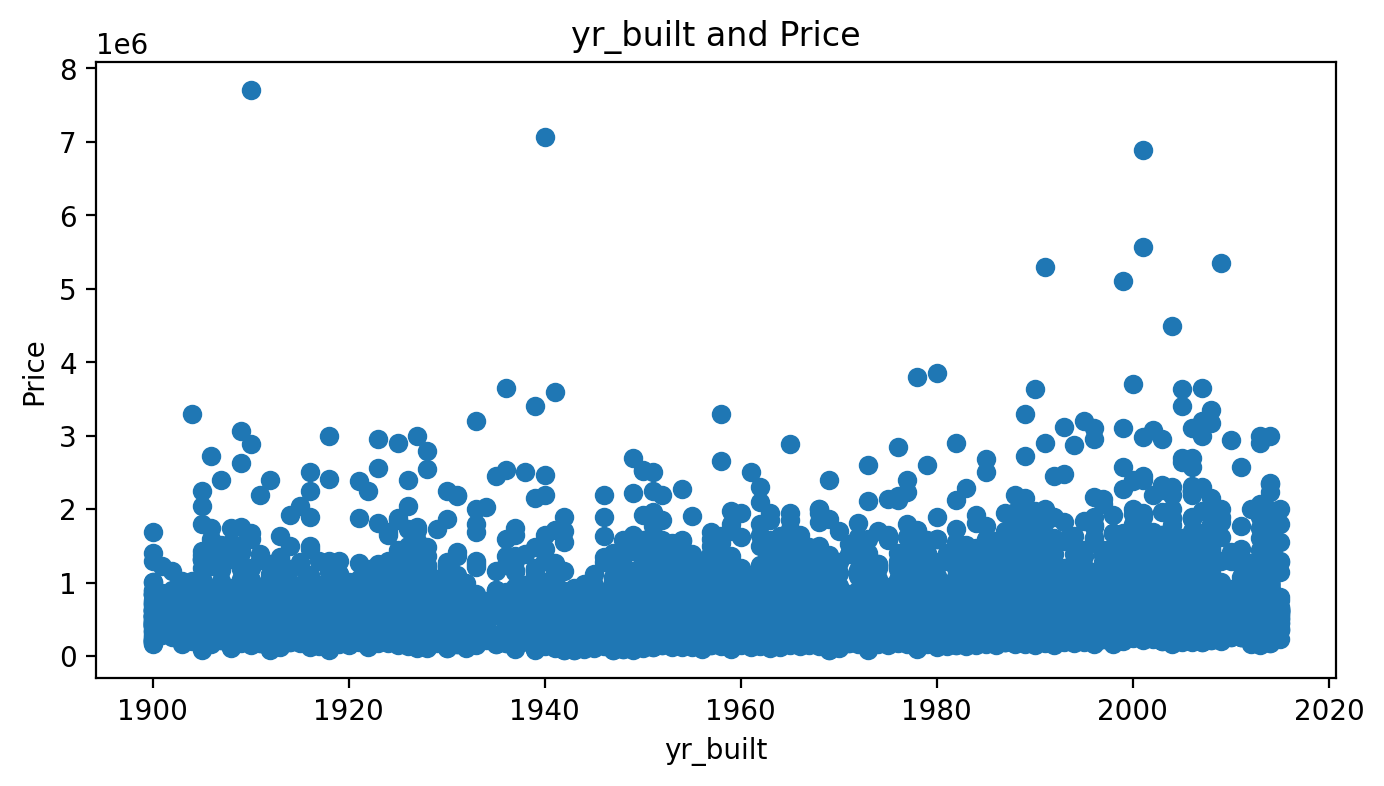

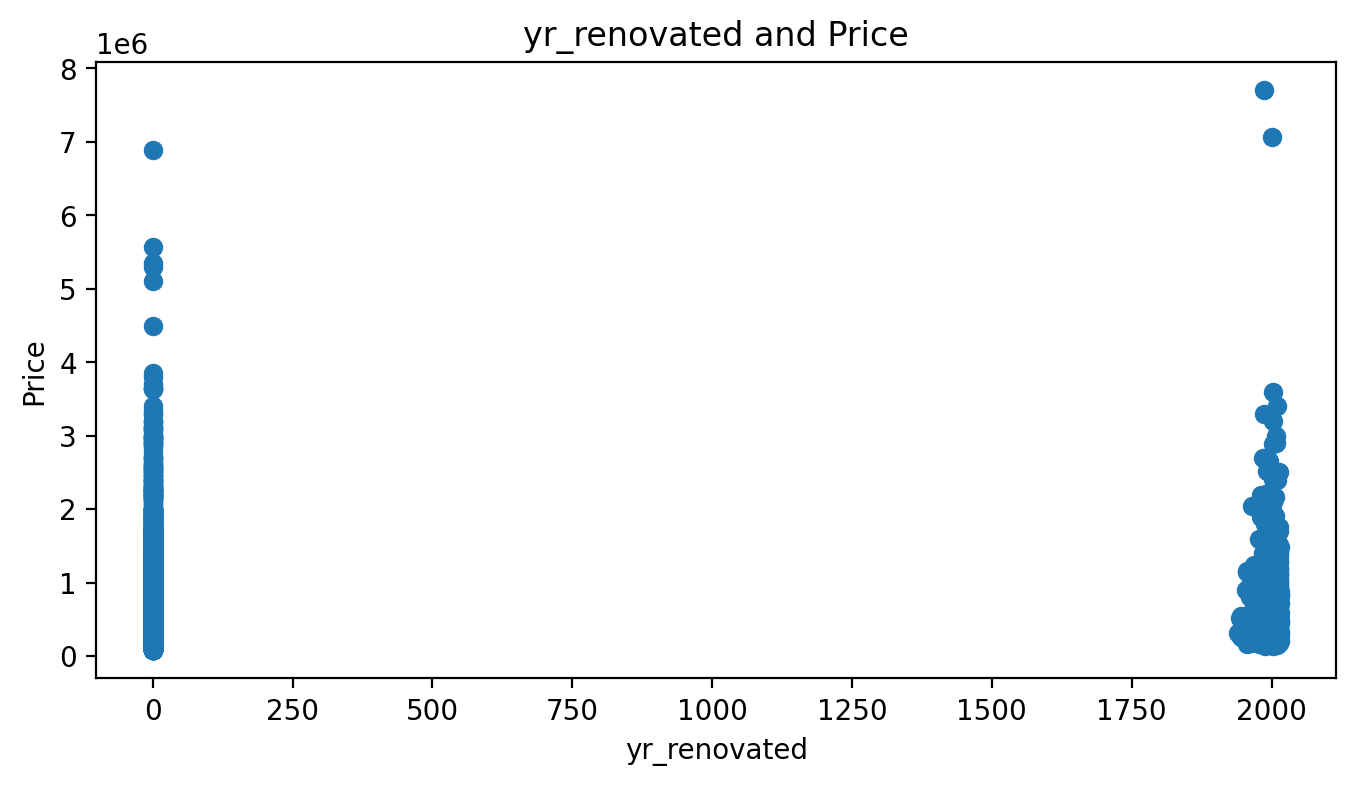

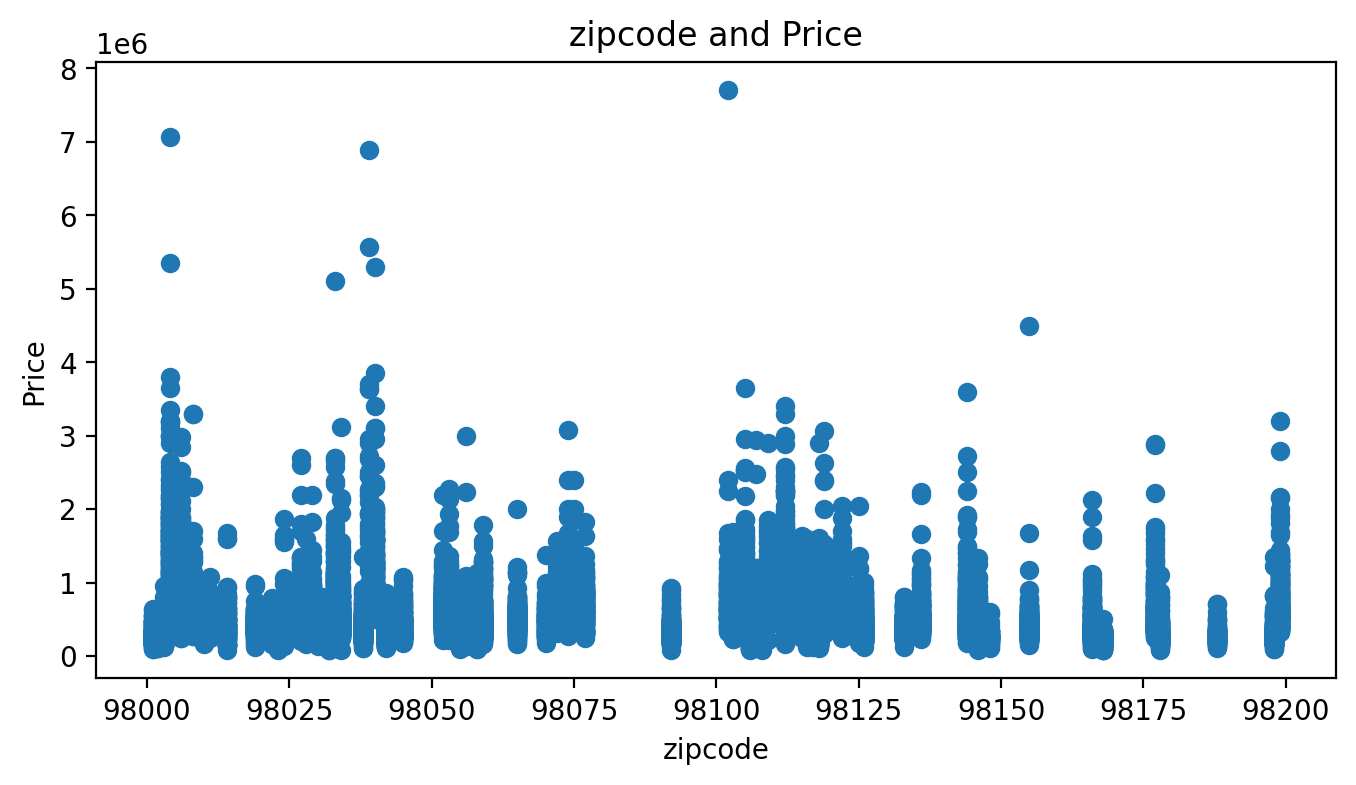

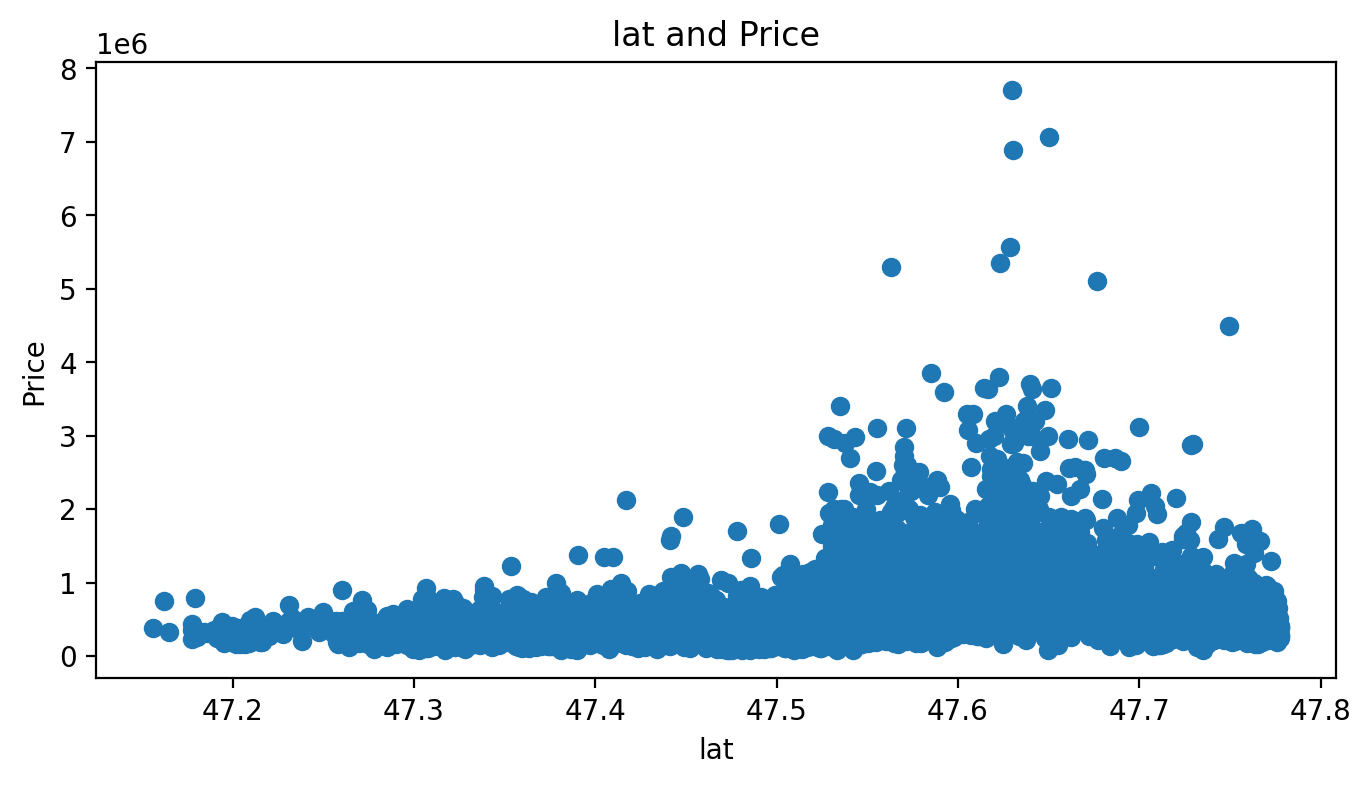

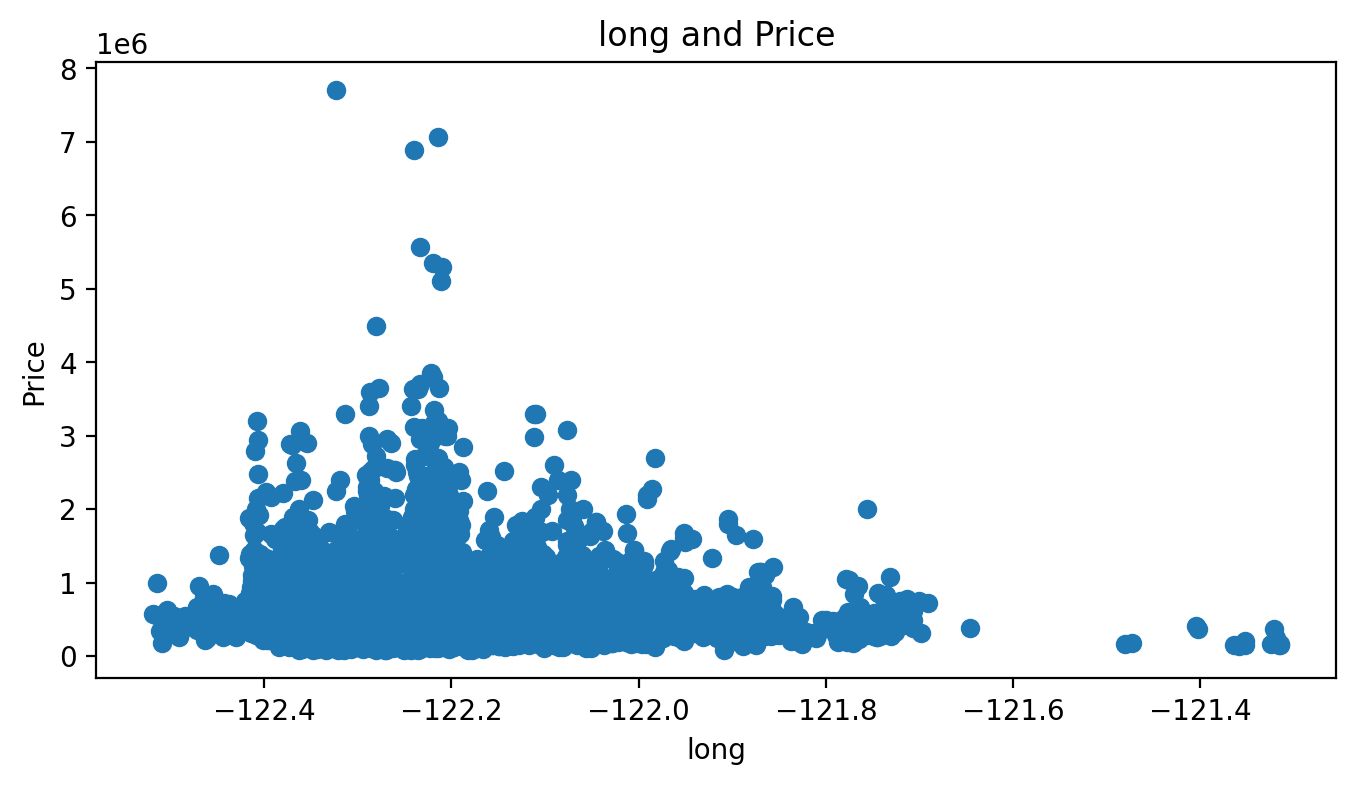

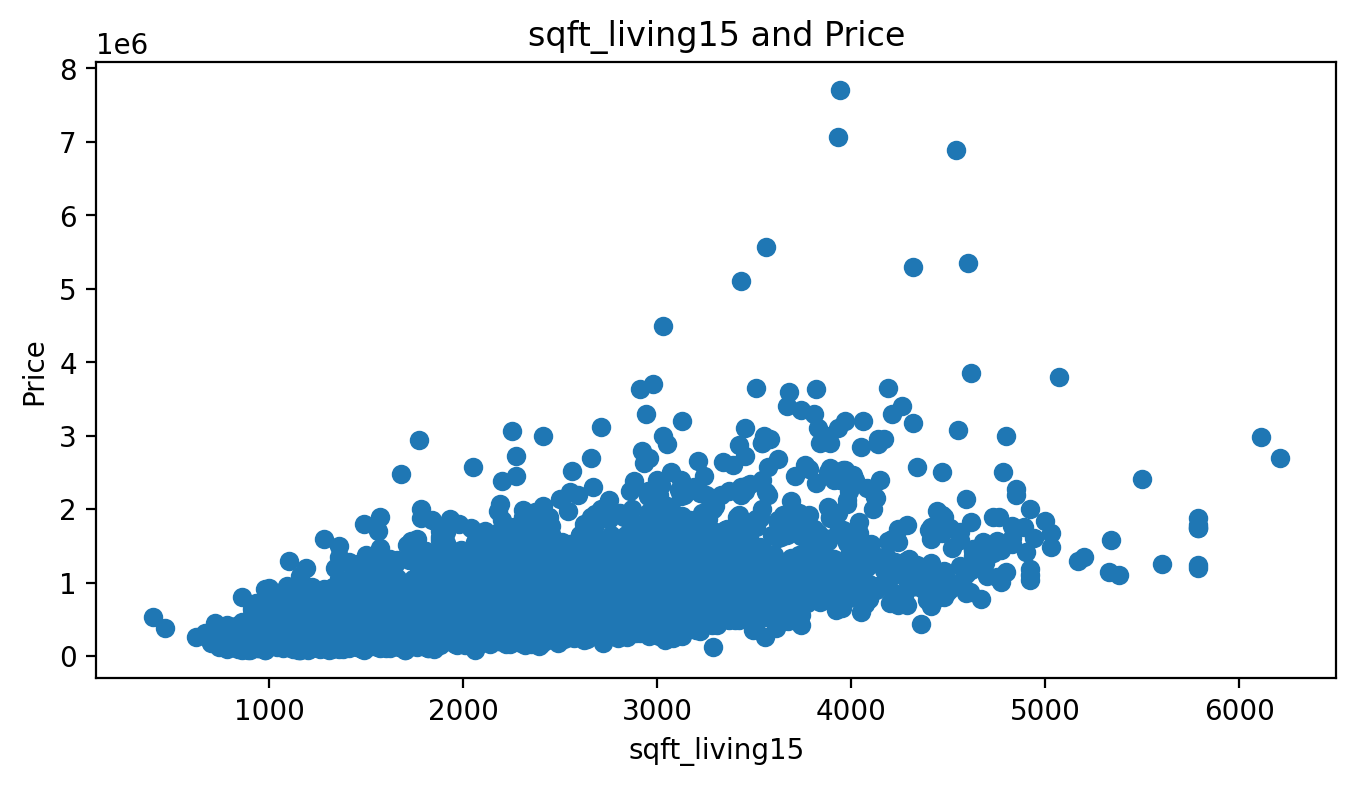

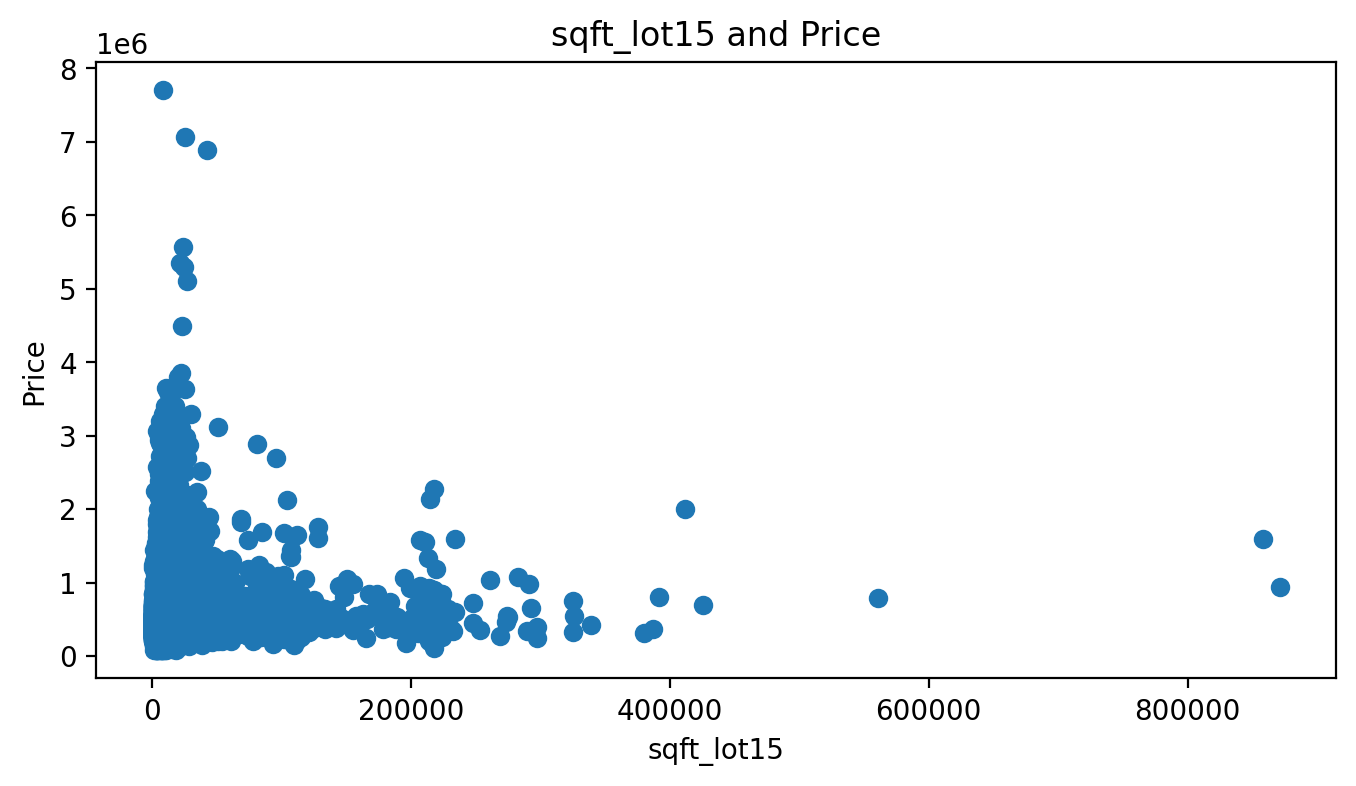

In [ ]:
# price와 변수의 관계 시각화

import matplotlib.pyplot as plt

for column in train.columns:
    if column != 'price':
        plt.figure(figsize=(8, 4))
        plt.scatter(train[column], train['price'])
        plt.title(f'{column} and Price')
        plt.xlabel(column)
        plt.ylabel('Price')
        plt.show()

id : 상관없음  
date : 오히려 최근의 데이터의 금액이 낮아지는 경향  
bedrooms : 중간값이 가장 높고 매매 건수도 많음  
bathrooms : 뒤로 갈수록 커지지만 커지는 경향.. 뒤로 갈 수록 매매 건수가 잘 없어서 이상치인지 적당한 금액인지 분간이 안됨  
sqft_living : 넓어질수록 금액도 커지지만..제일 넓은 집이 갑자기 금액 작아짐 이상치..?  
floor : 2층이 가장 금액이 높음  
waterfront : 리버뷰 있건 없건 가격 비슷함  
view : 0점이 가장 많았지만 금액적으로는 사실 상관이 없는 듯함  




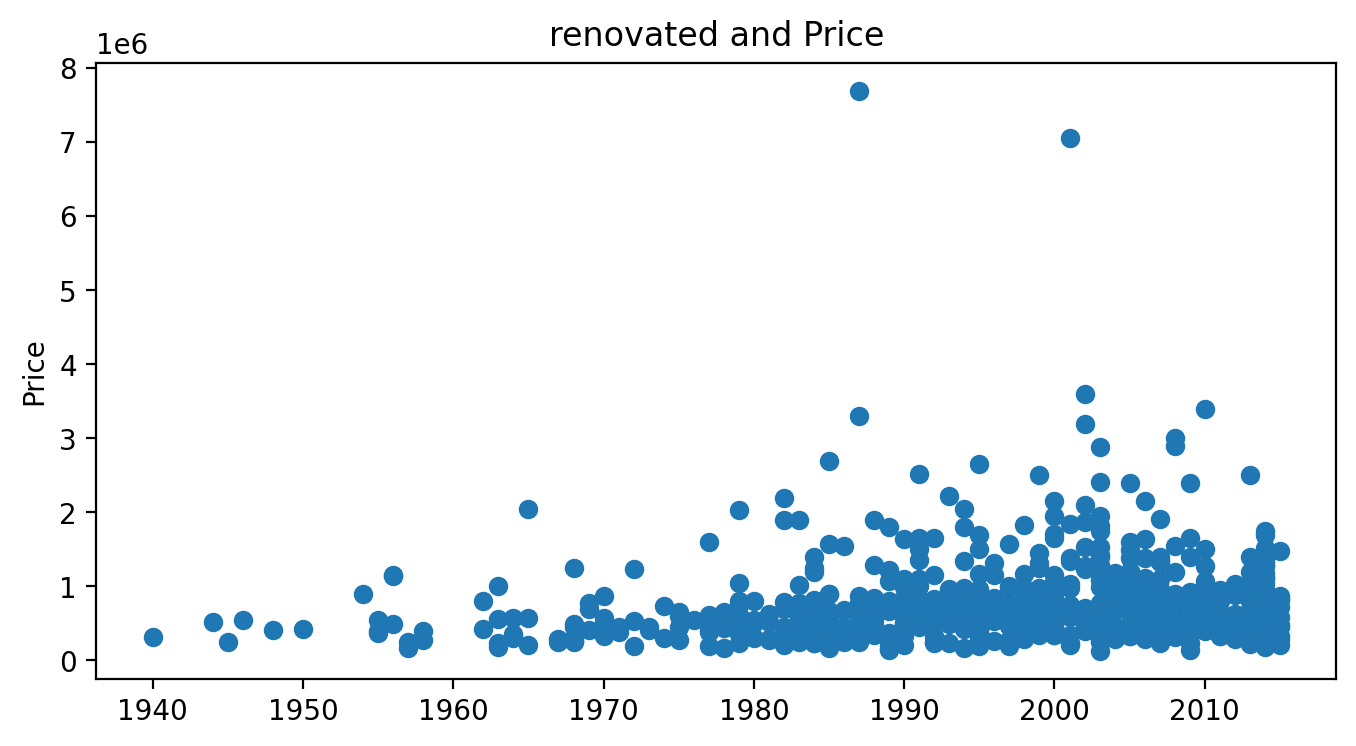

In [ ]:
# 재건축한 데이터만 확인
train_renovated = train[(train['yr_renovated'] != 0)]


plt.figure(figsize=(8, 4))
plt.scatter(train_renovated['yr_renovated'], train_renovated['price'])
plt.title(f'renovated and Price')
plt.xlabel('')
plt.ylabel('Price')
plt.show()

재건축 데이터는 최근일수록 건수도 많아지고 금액대도 높아지는 경향을 보임  
하지만 price와 상관성이 없는 이유를 찾지 못함. (0이 너무 많아서?)  

### 데이터 전처리

In [ ]:
# price 데이터 삭제

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
# train 데이터와 test 데이터 합치기
# 나중에 분리하기 위해 train 길이 저장

train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [ ]:
# 분석에 필요없는 id 데이터 삭제

del data['id']

In [ ]:
# date 데이터 int형으로 변경

data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lot15  

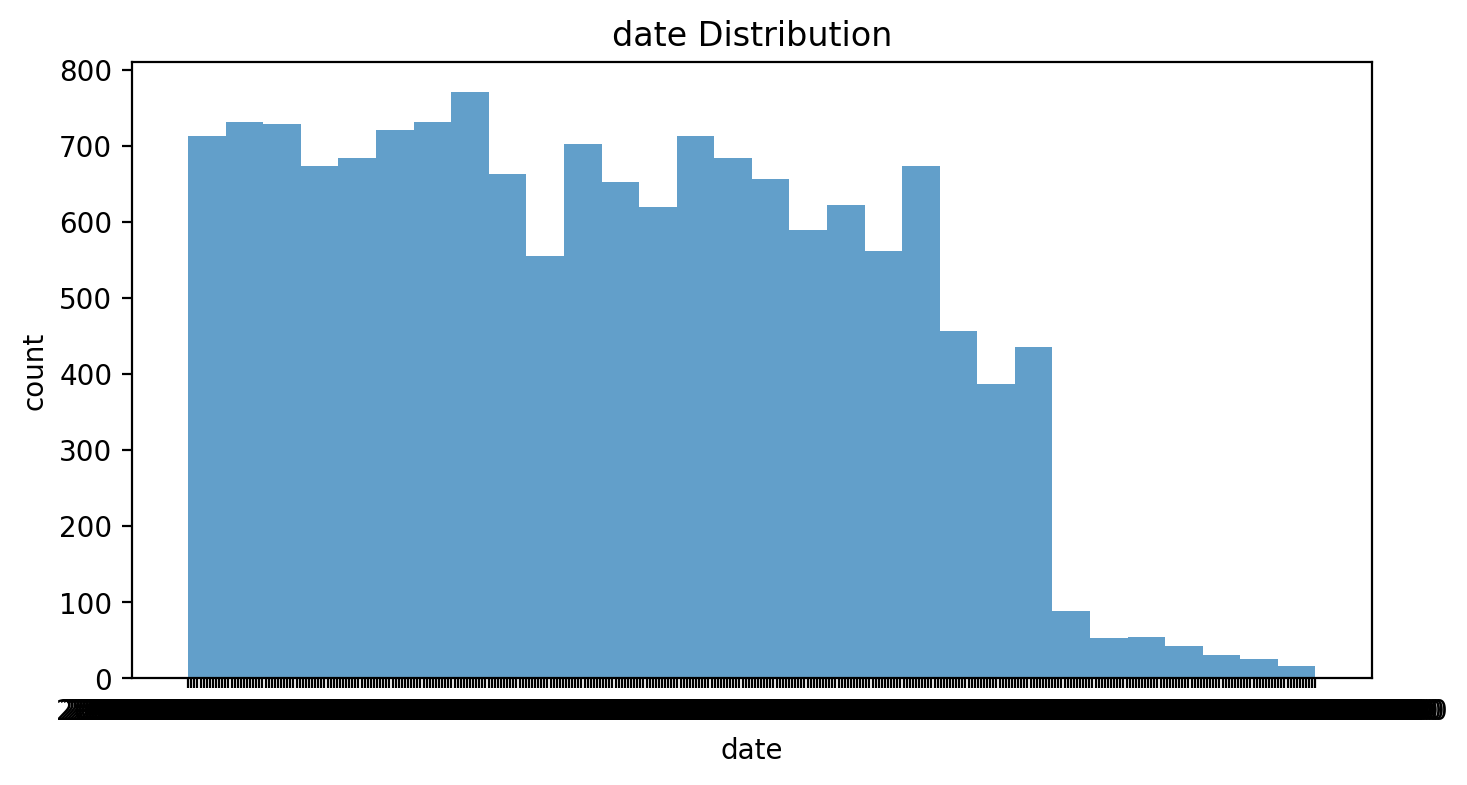

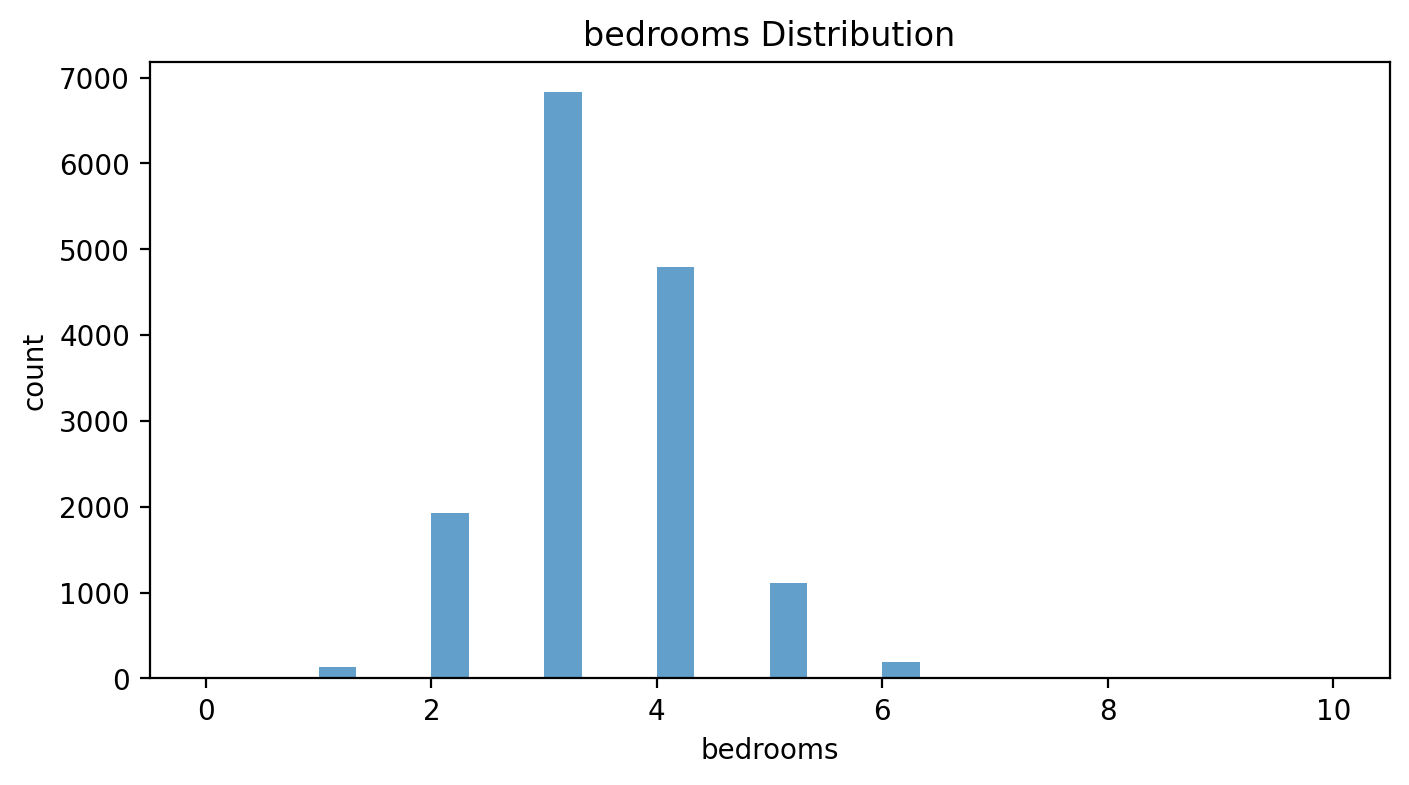

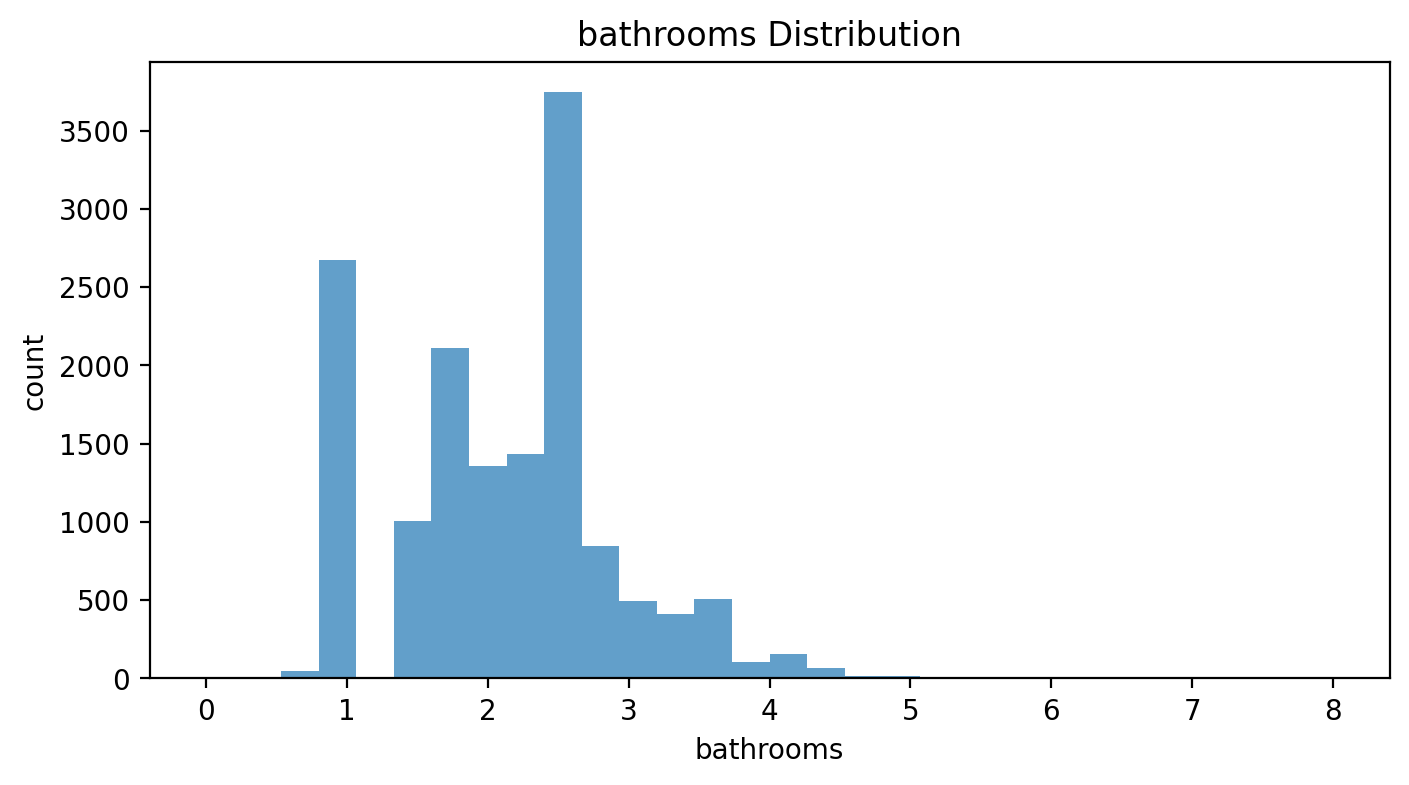

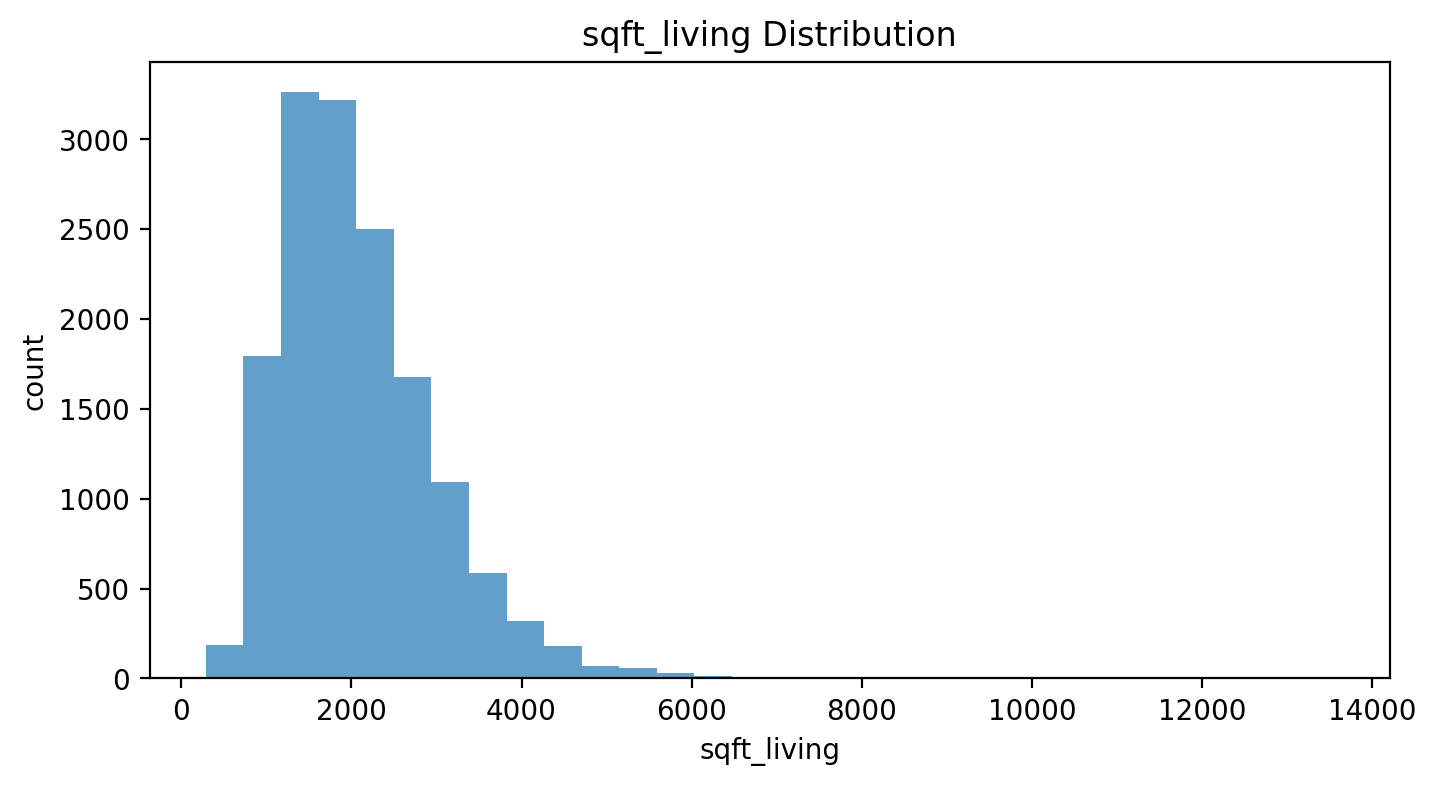

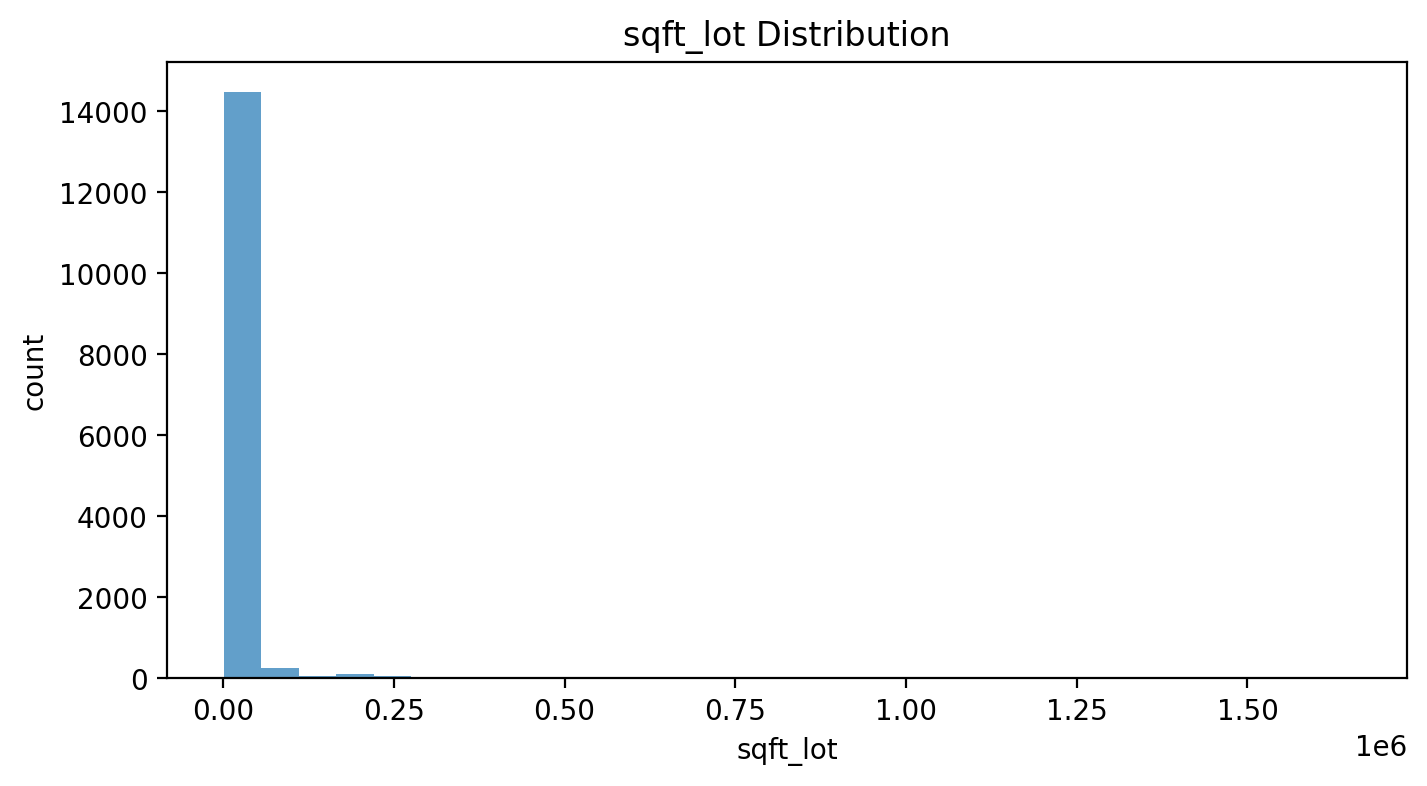

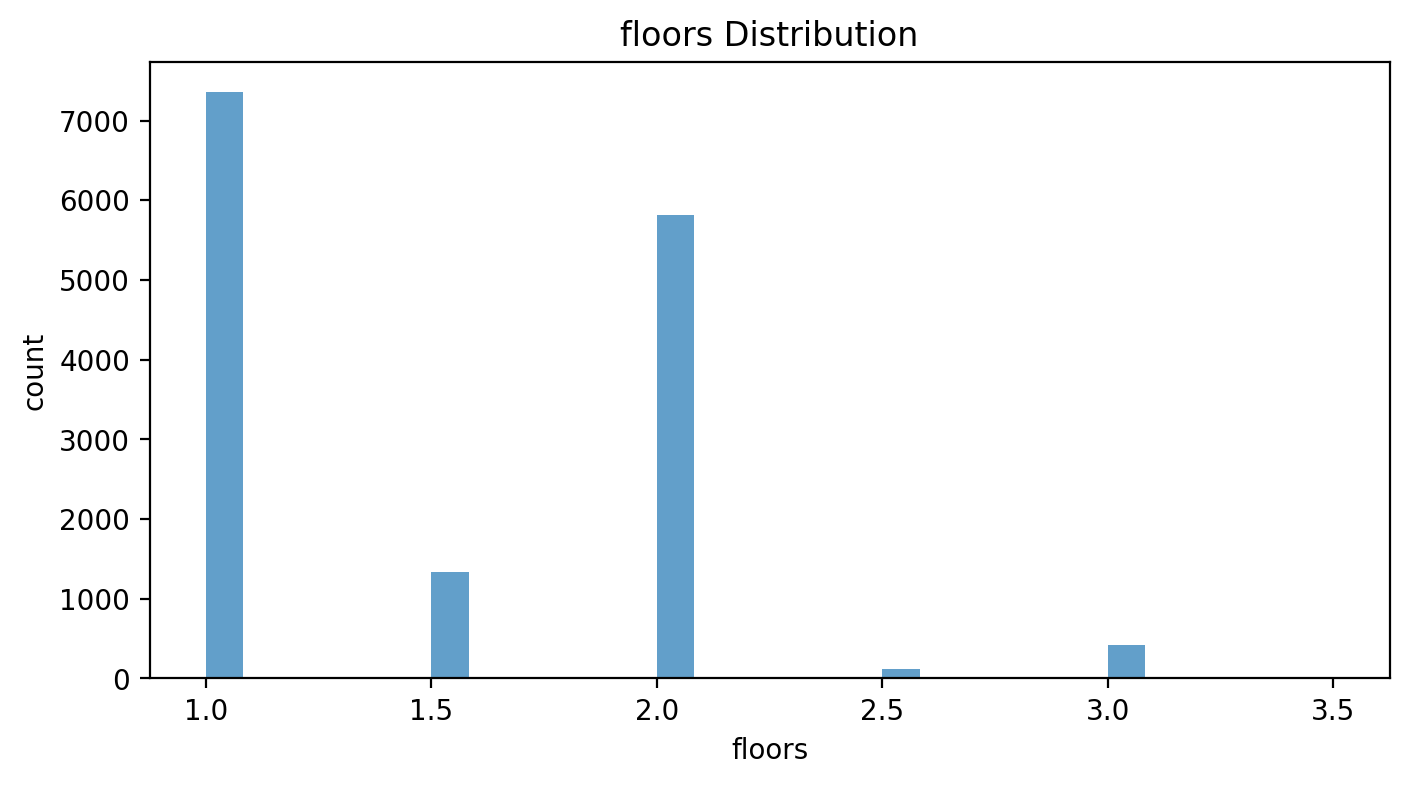

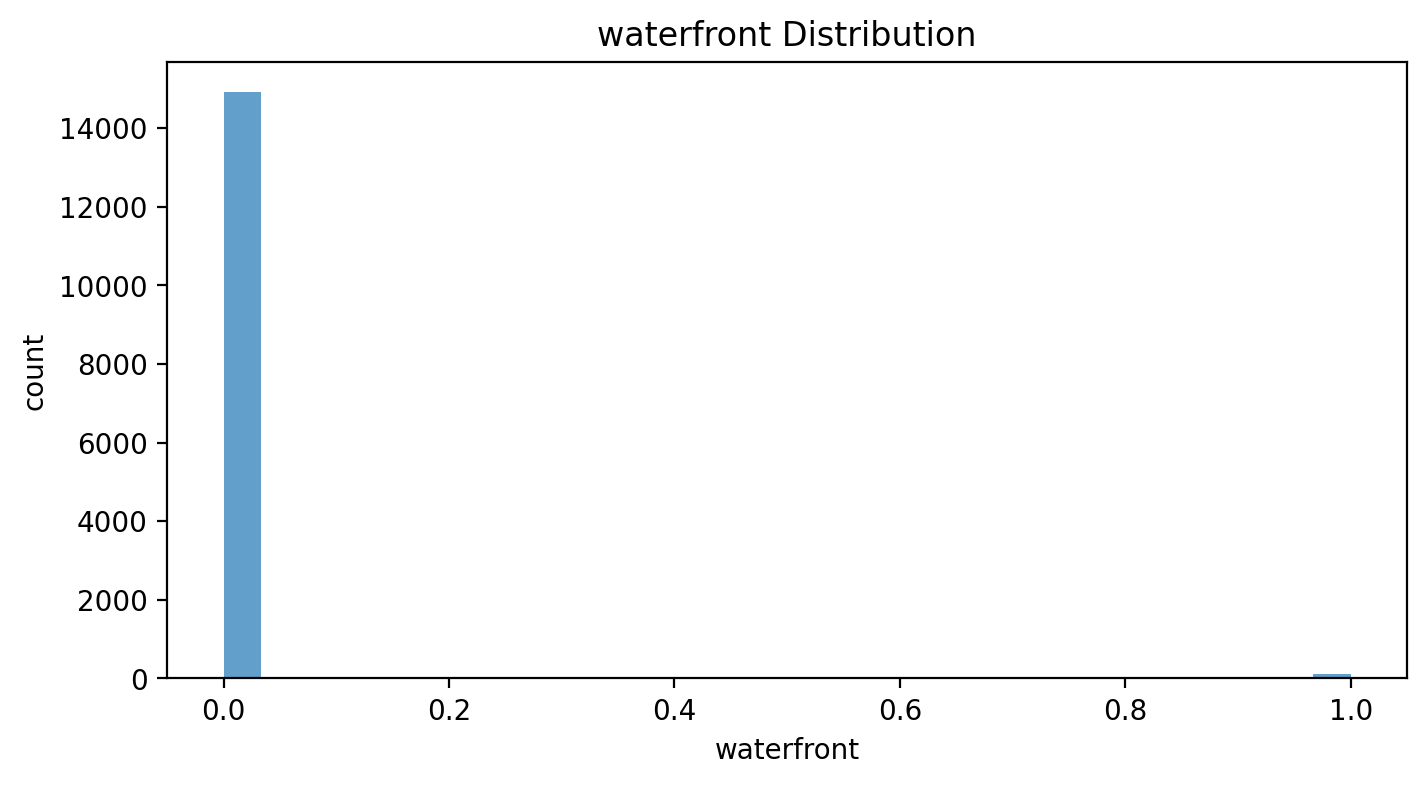

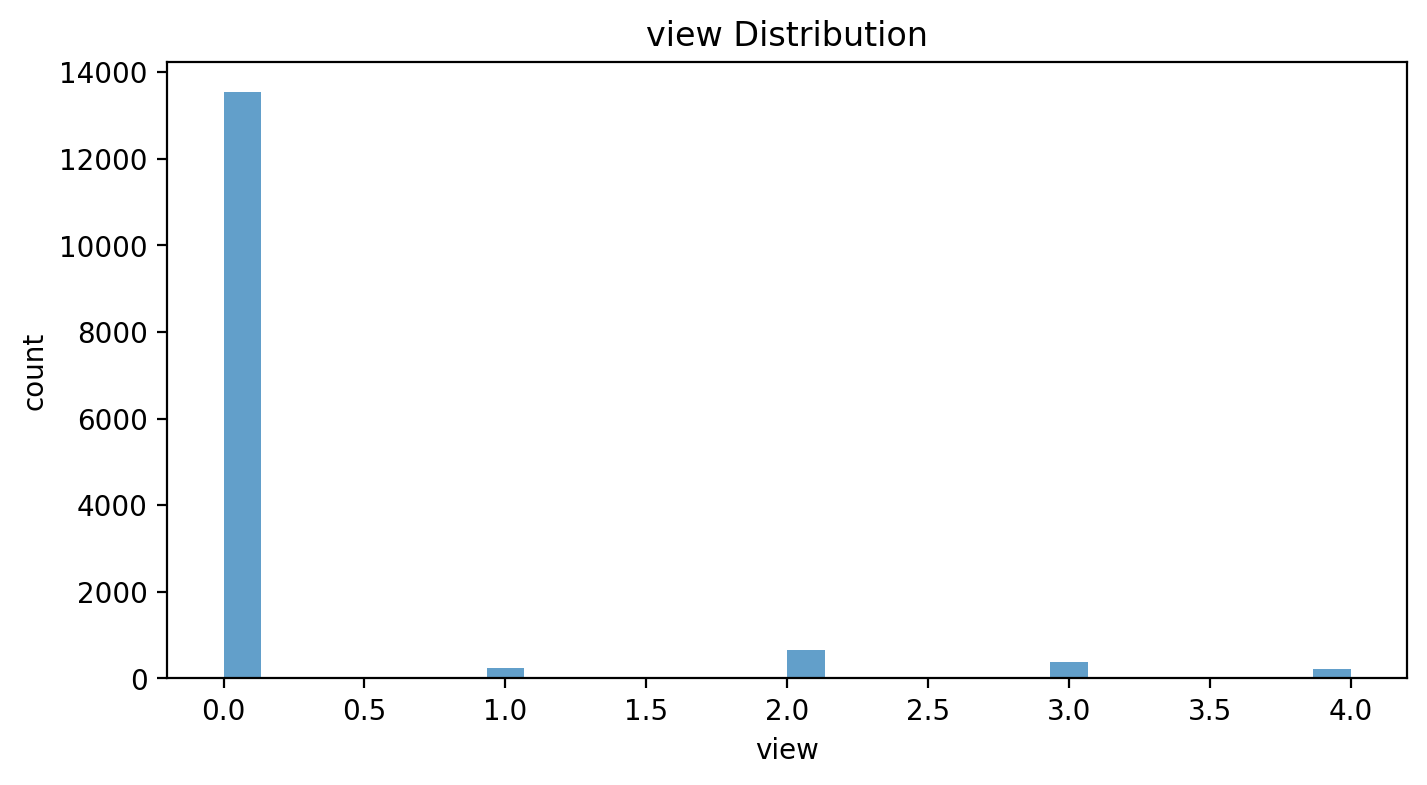

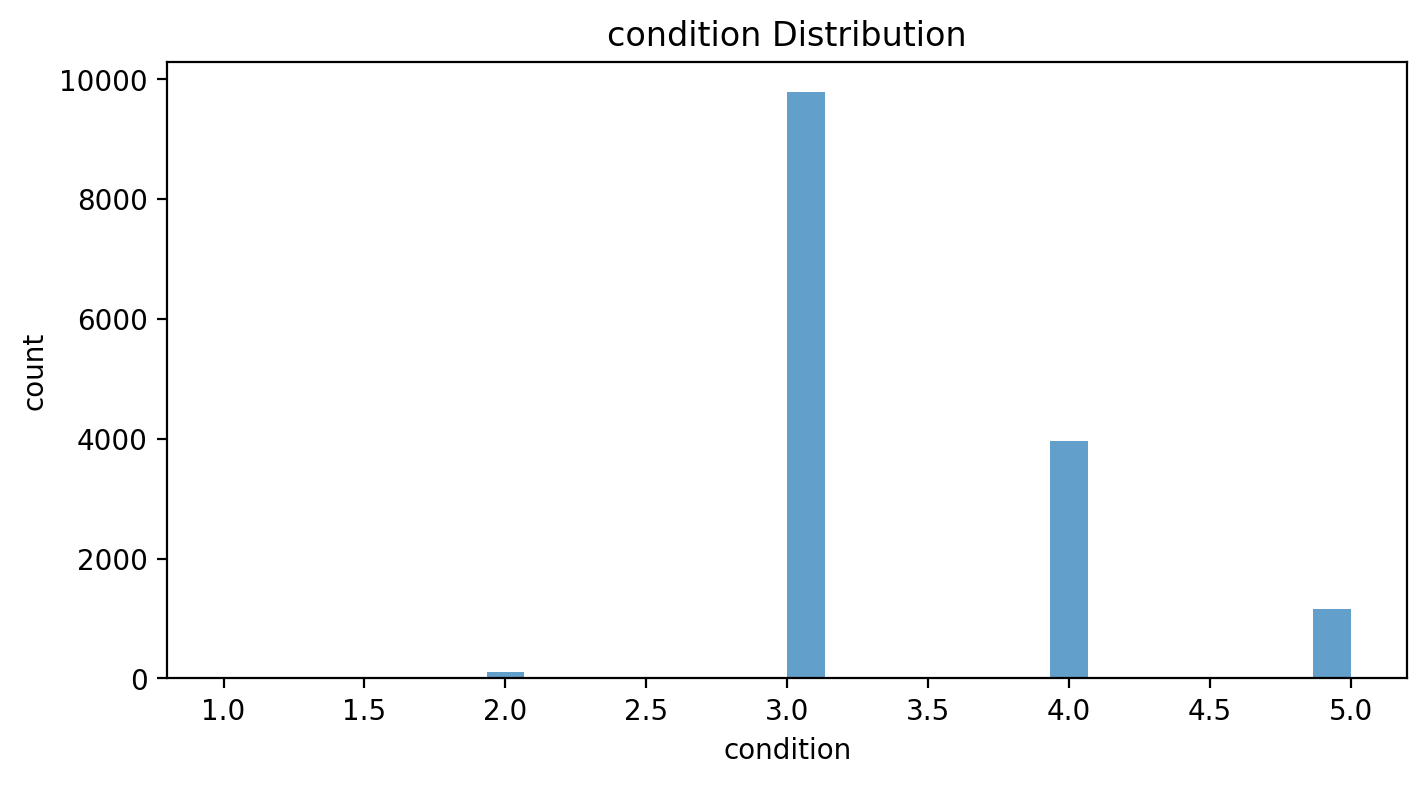

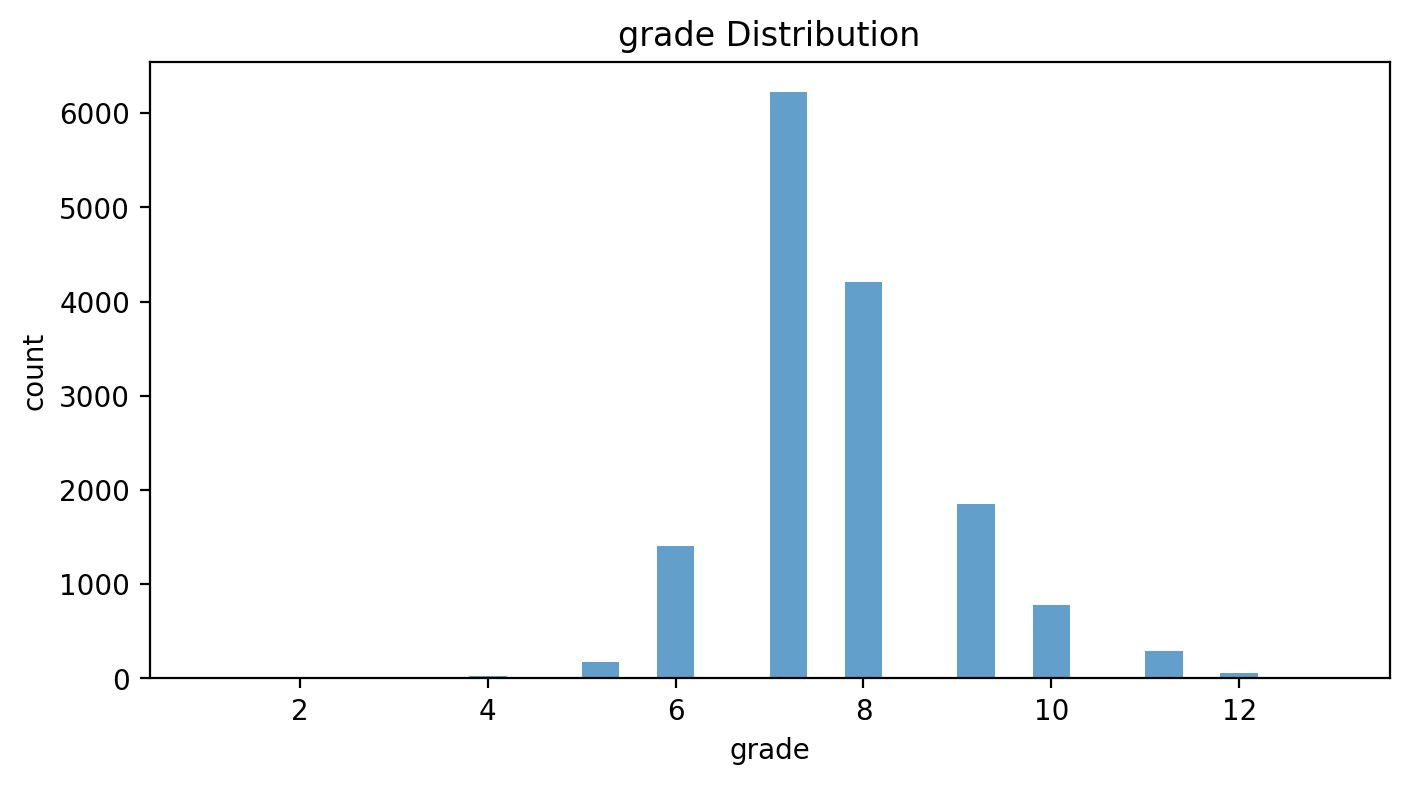

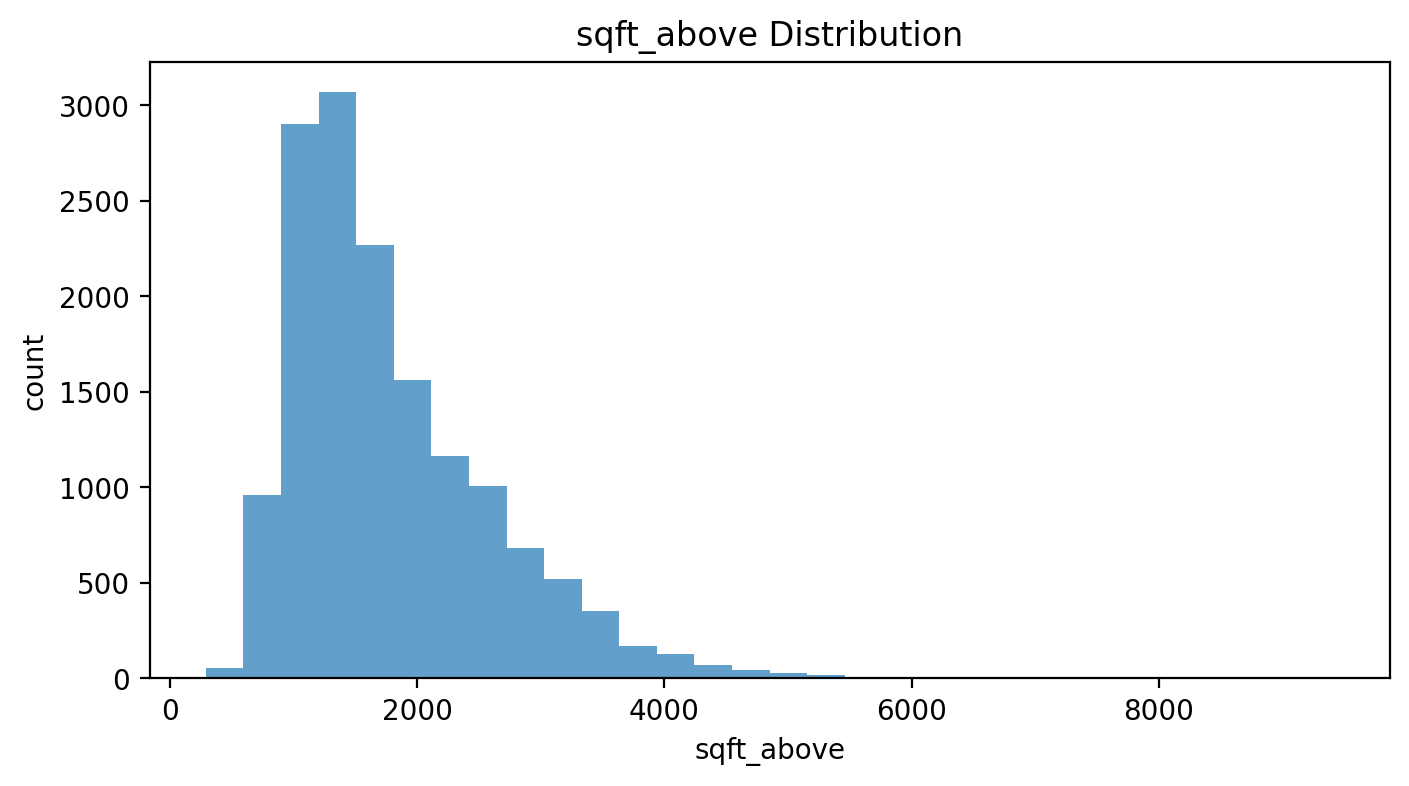

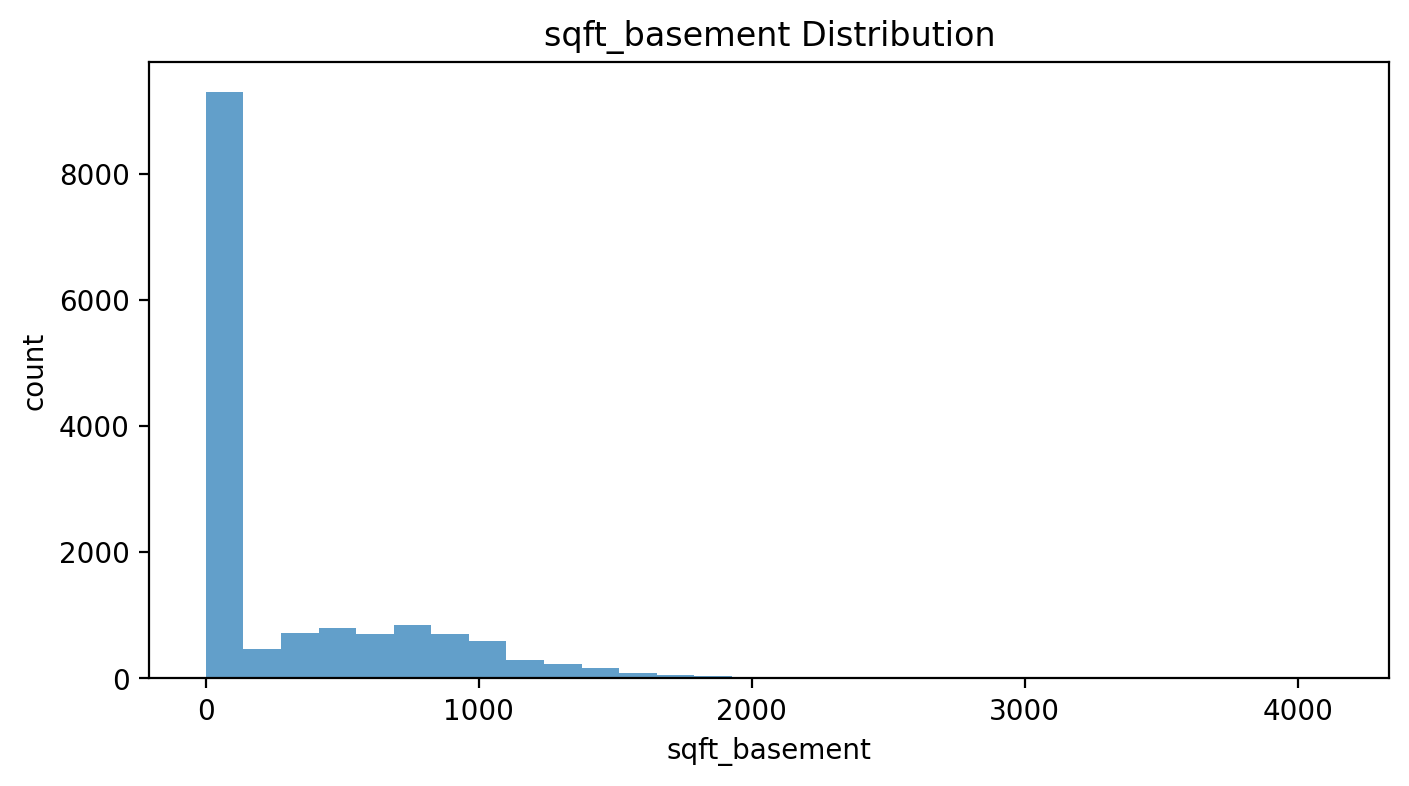

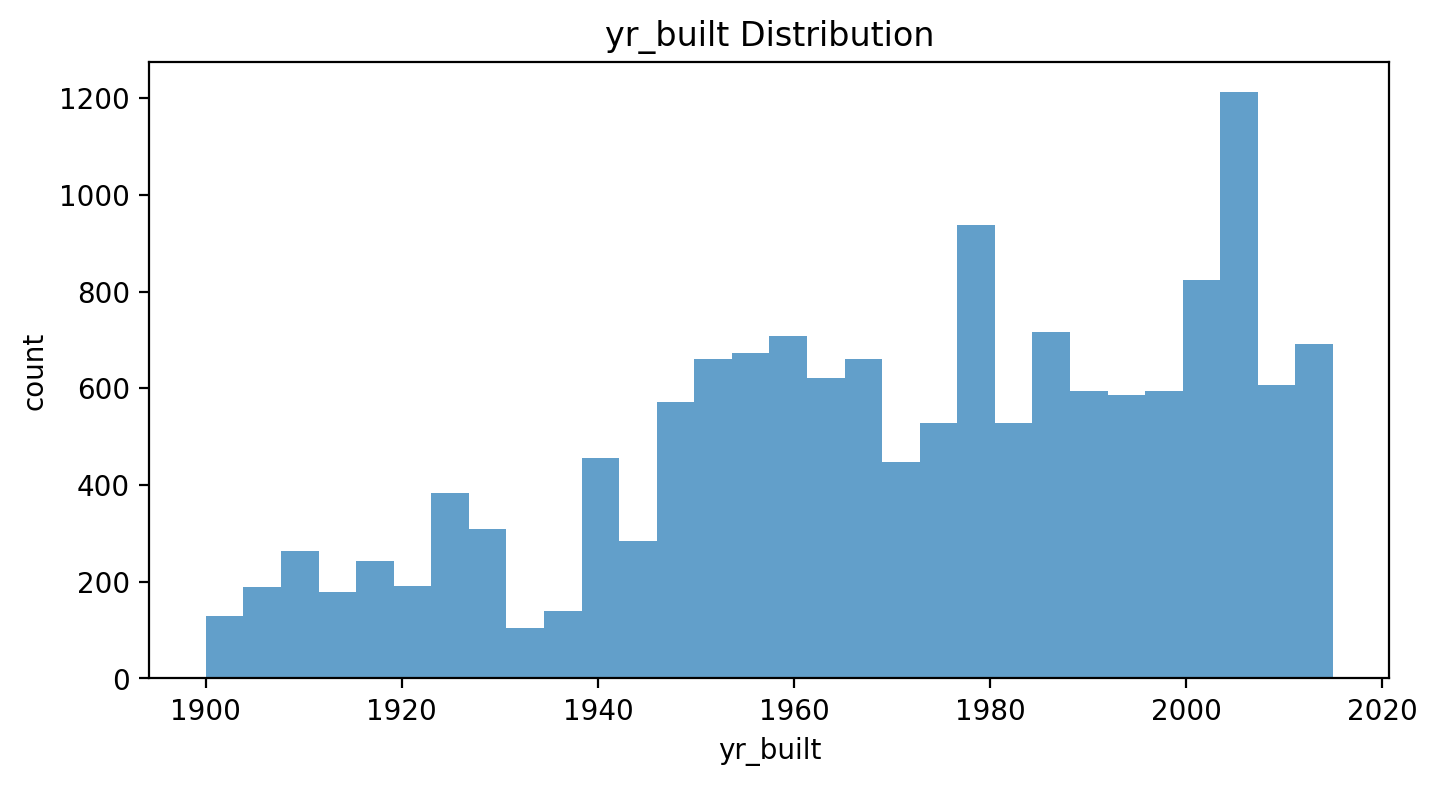

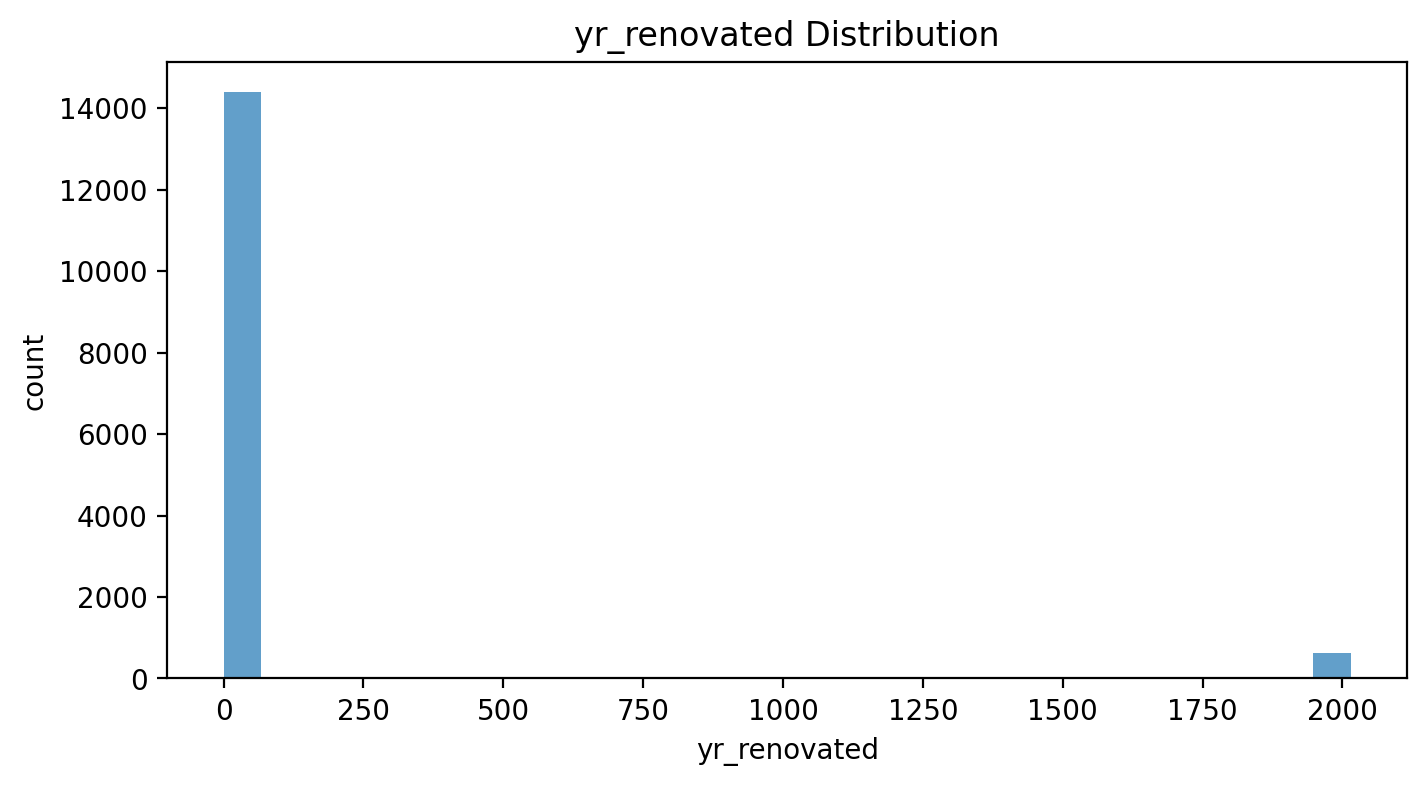

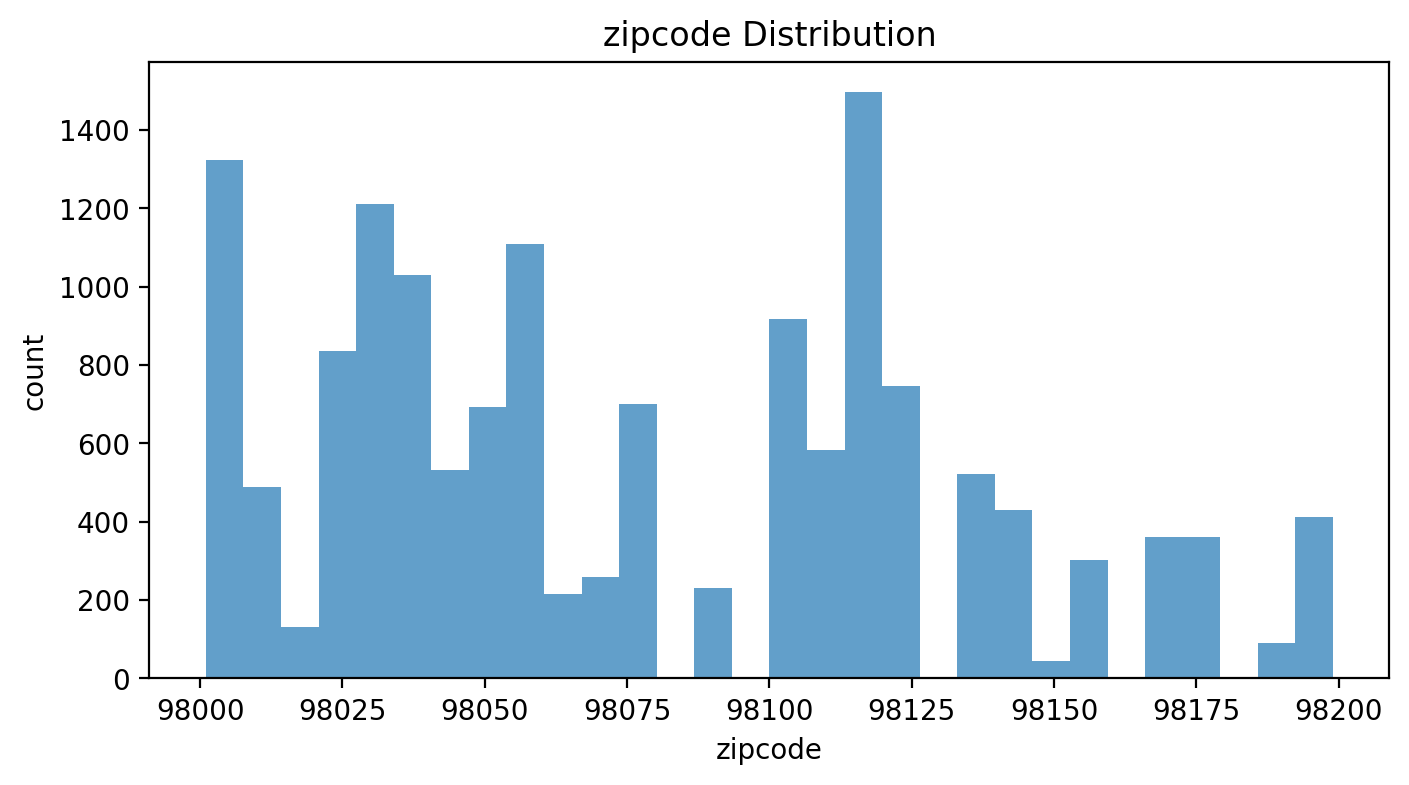

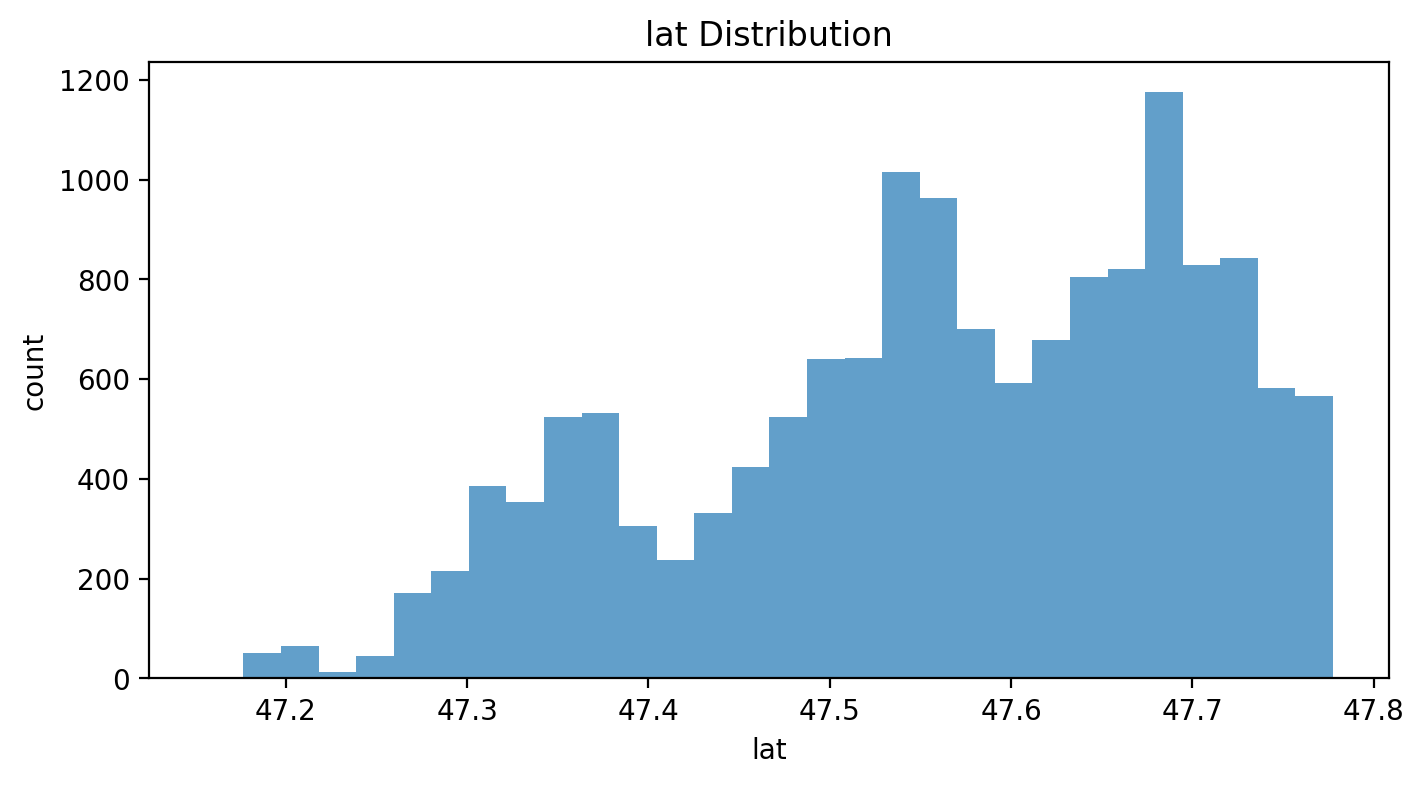

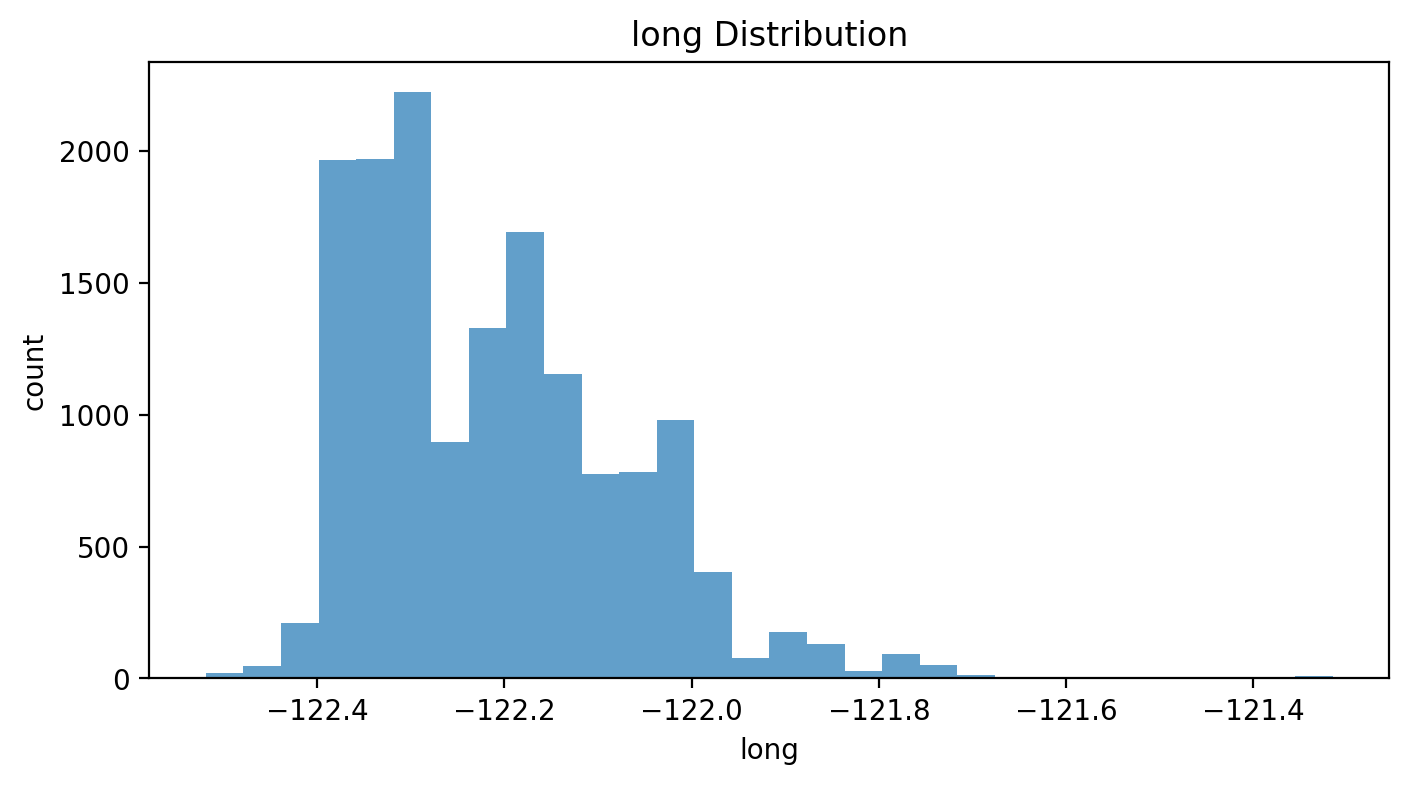

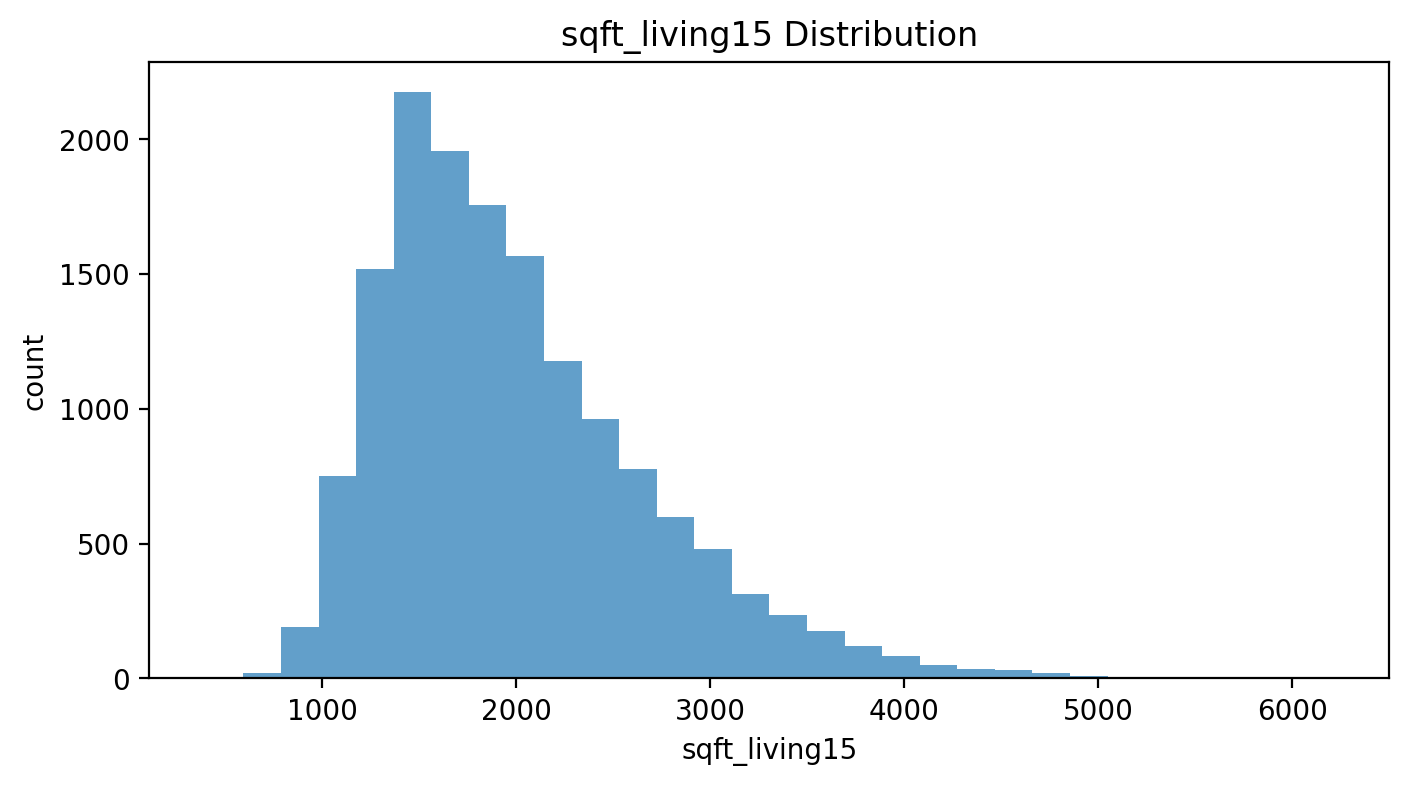

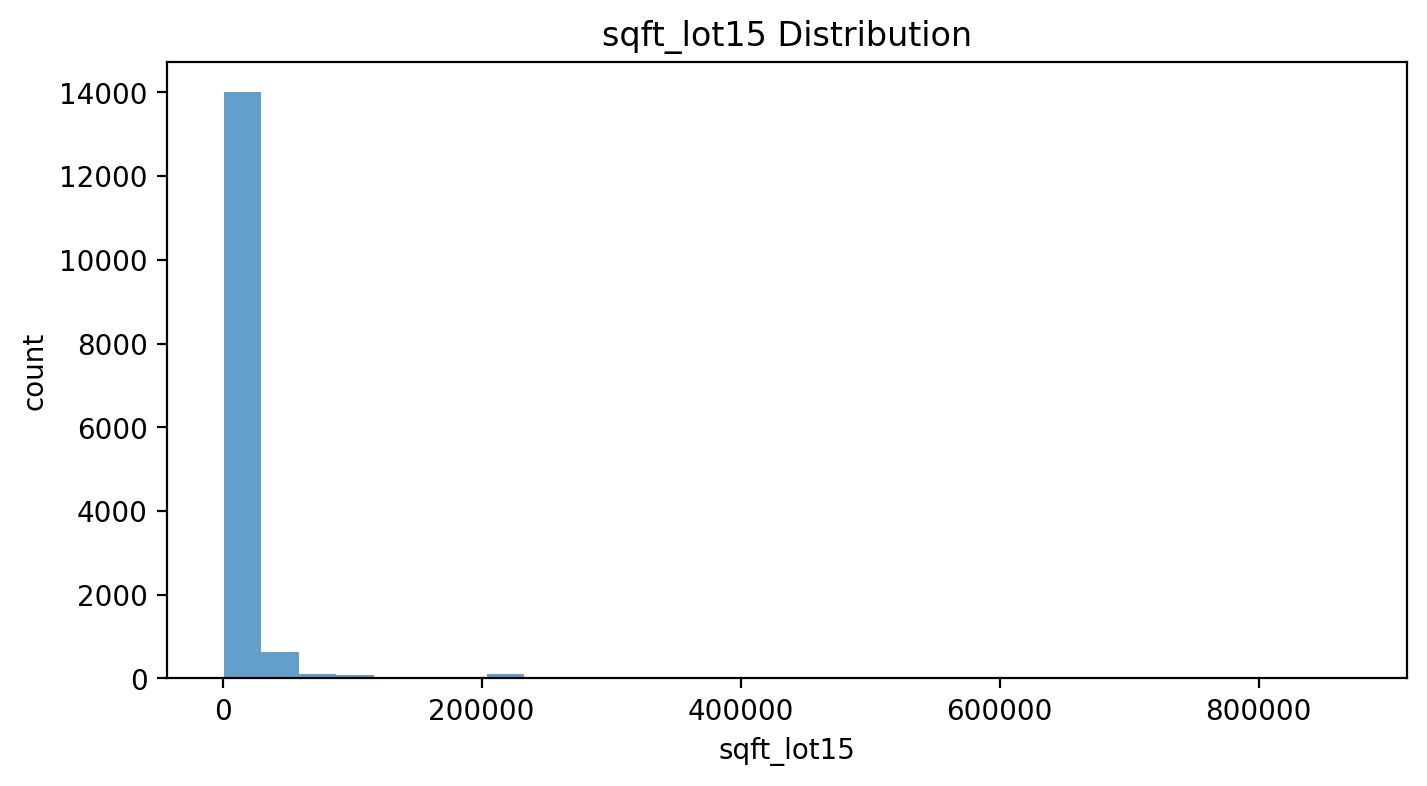

In [ ]:
# 전체 데이터 확인

for column in data.columns:
    if column != 'price':
        plt.figure(figsize=(8, 4))
        plt.hist(train[column], bins=30, alpha=0.7)
        plt.title(f'{column} Distribution')
        plt.xlabel(column)
        plt.ylabel('count')
        plt.show()


date : 최근으로 갈수록 매매량 적어짐   
sqft_lot : price 데이터와 약한 상관관계 + 산점도와 그래프에서 인사이트 찾기 힘듦 -> 삭제  
condition : price 데이터와 약한 상관관계 + 산점도와 그래프에서 인사이트 찾기 힘듦 -> 삭제  
waterfront : 리버뷰인 집은 거의 없다시피함  
view : 0점을 받은 집이 압도적으로 많음  
sqft_basement : 지하실이 없는 집이 압도적으로 많음  
yr_built : 건축연도는 최근일수록 더 많아짐  
yr_renovated : 재건축하지 않은 집이 압도적으로 많음  
zipcode : 우편번호는 범주형으로 분류해야함  
lat : 위도는 높을수록 매매량이 많음  
long : 경도는 낮을수록 매매량이 많음  
sqft_lot15 : price 데이터와 약한 상관관계 + 산점도와 그래프에서 인사이트 찾기 힘듦 -> 삭제  

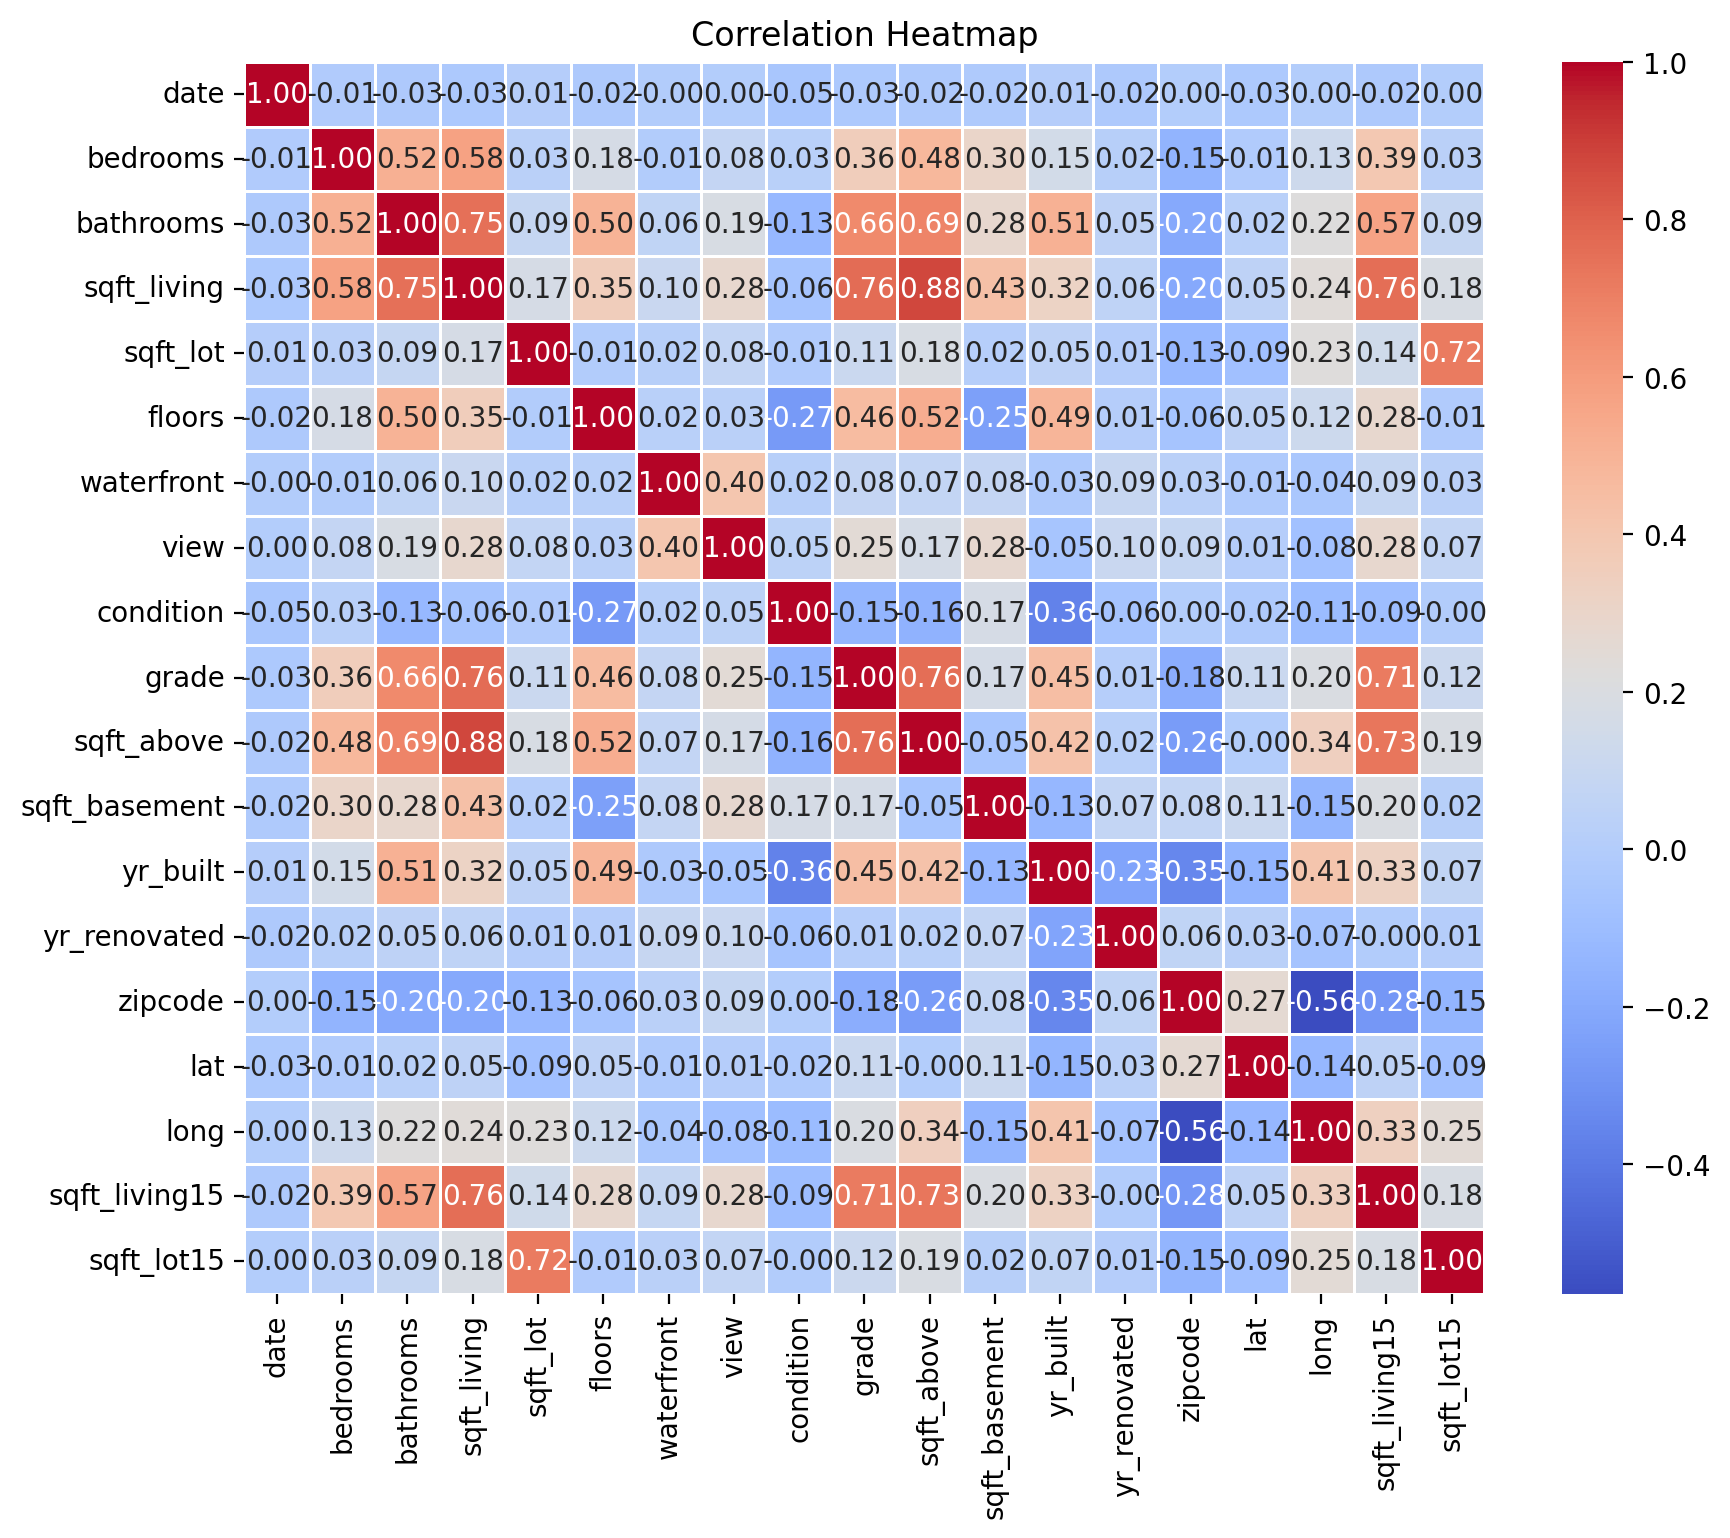

In [ ]:
# 수치형 데이터만 선택
numeric_data = data.select_dtypes(include=['number'])

# 상관 계수 계산
corr = numeric_data.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# 상관 행렬 계산
corr_matrix = data.corr()

# 자기 자신과의 상관 계수를 제외한 최댓값과 최솟값 계산
corr_matrix_no_diag = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))

# 각 변수별 최댓값과 최솟값을 구하기 (자기 자신 제외)
max_corr_values = corr_matrix_no_diag.max()
min_corr_values = corr_matrix_no_diag.min()

# 변수별 최댓값과 최솟값을 리스트 형태로 반환
max_min_corr = pd.DataFrame({
    'max_corr': max_corr_values,
    'min_corr': min_corr_values
})

# 출력
print(max_min_corr)

               max_corr  min_corr
date           0.005759 -0.046750
bedrooms       0.576623 -0.152680
bathrooms      0.754592 -0.203312
sqft_living    0.876625 -0.198704
sqft_lot       0.718115 -0.129338
floors         0.523414 -0.265105
waterfront     0.402785 -0.042085
view           0.402785 -0.079305
condition      0.173985 -0.363437
grade          0.762421 -0.183607
sqft_above     0.876625 -0.260537
sqft_basement  0.434663 -0.245757
yr_built       0.505297 -0.363437
yr_renovated   0.103318 -0.225682
zipcode        0.266695 -0.564271
lat            0.266695 -0.148113
long           0.409026 -0.564271
sqft_living15  0.756189 -0.278365
sqft_lot15     0.718115 -0.146901


### 결측치 확인

<Axes: >

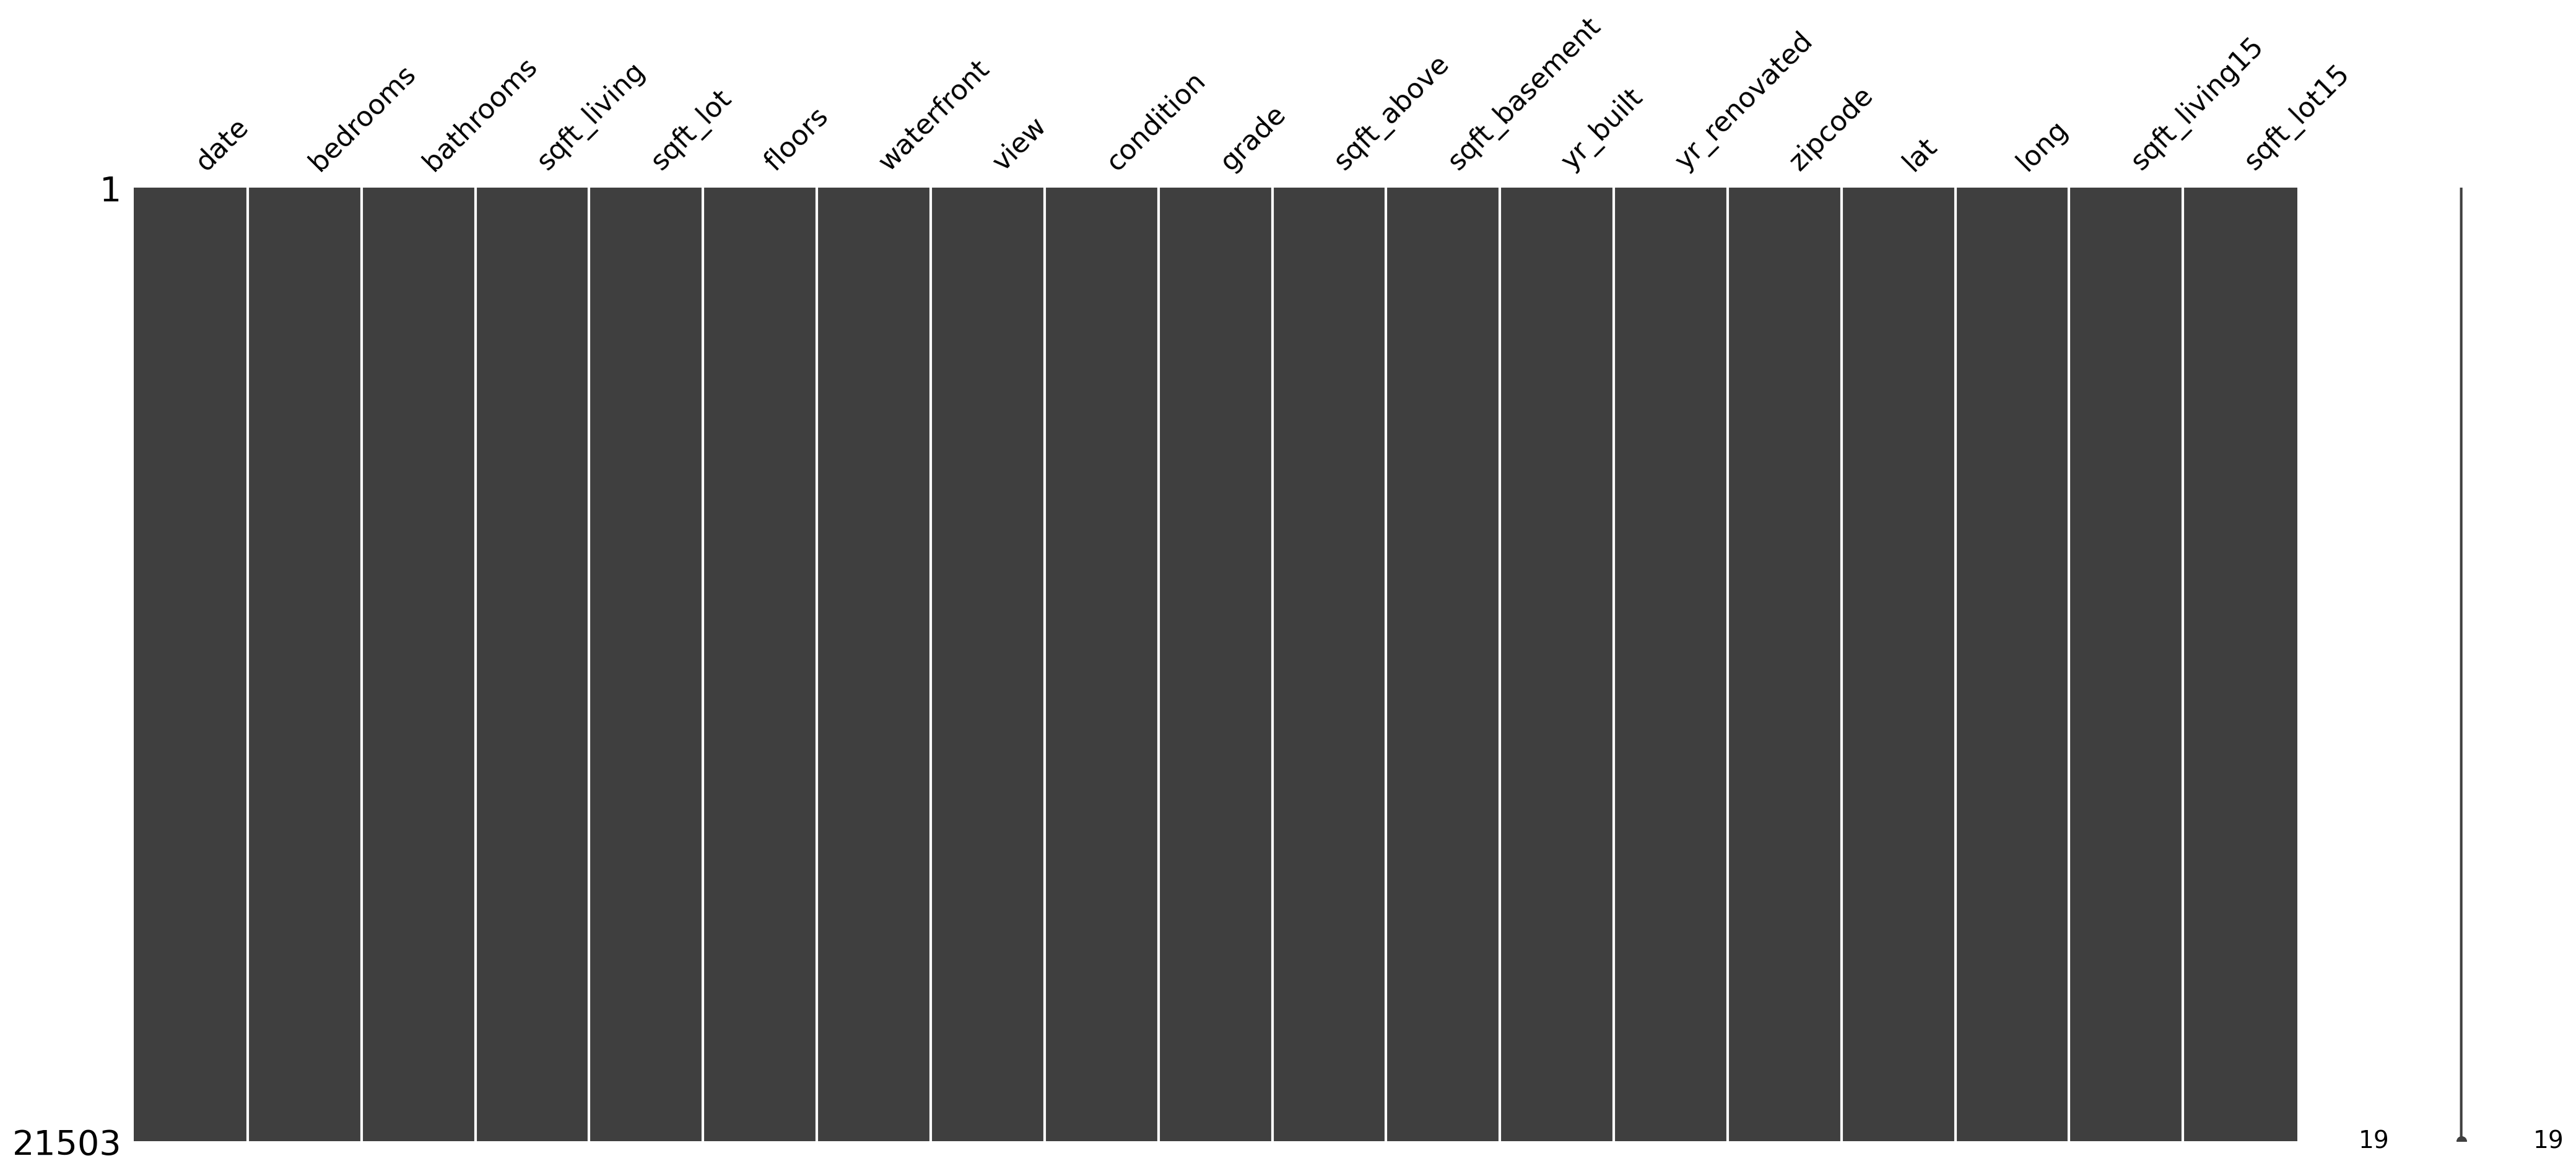

In [ ]:
# mano.matrix : 매트릭스 결측치 시각화, 결측치 하얗게 표시

msno.matrix(data)

In [ ]:
# 칼럼 별 결측치 확인

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 이상치 제거

In [ ]:
# 가격이 너무 튀는 데이터 제거 하고 싶어서 상위 20개 데이터 뽑아보기 -> 일단 보류

# data2 = data[(data['waterfront'] == 1)].sort_values(by='view', ascending=True)
# data2.head(20)

# 보통 waterfront가 1인 경우, view가 3점 이상인 것으로 보아 뷰값(?)으로 가격이 높게 책정되지 않나 하는 생각

### 데이터 분포 확인

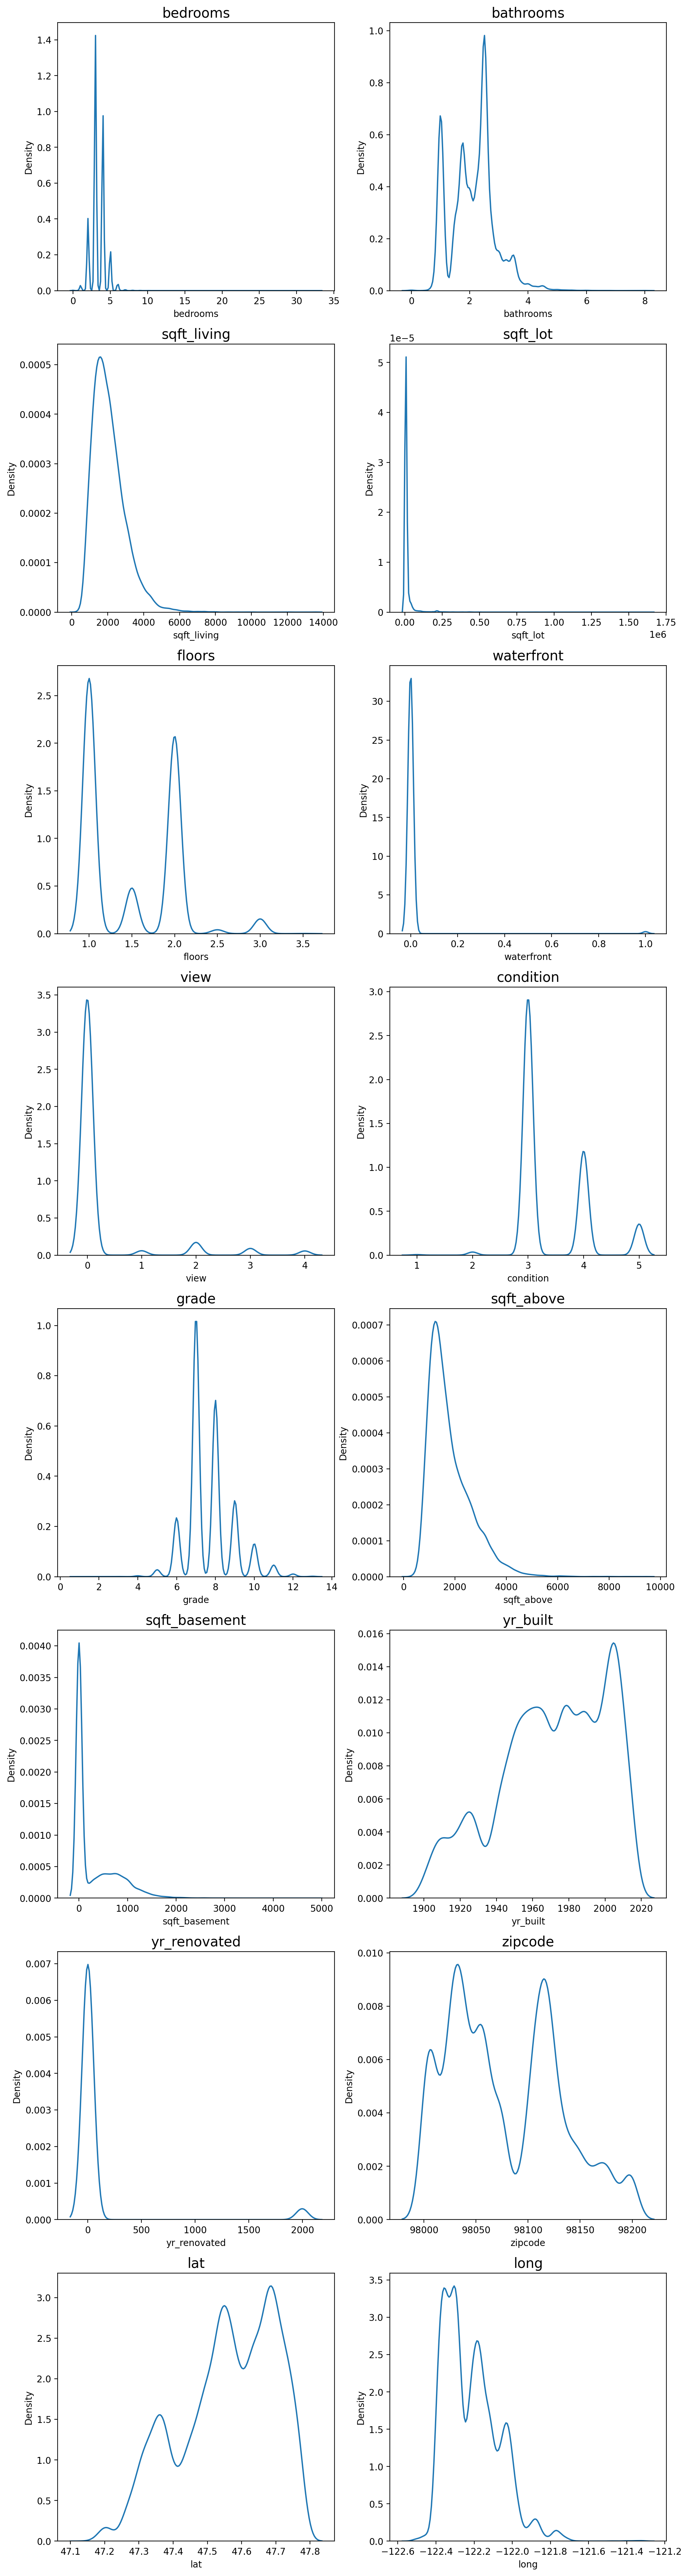

In [ ]:
fig, ax = plt.subplots(8, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

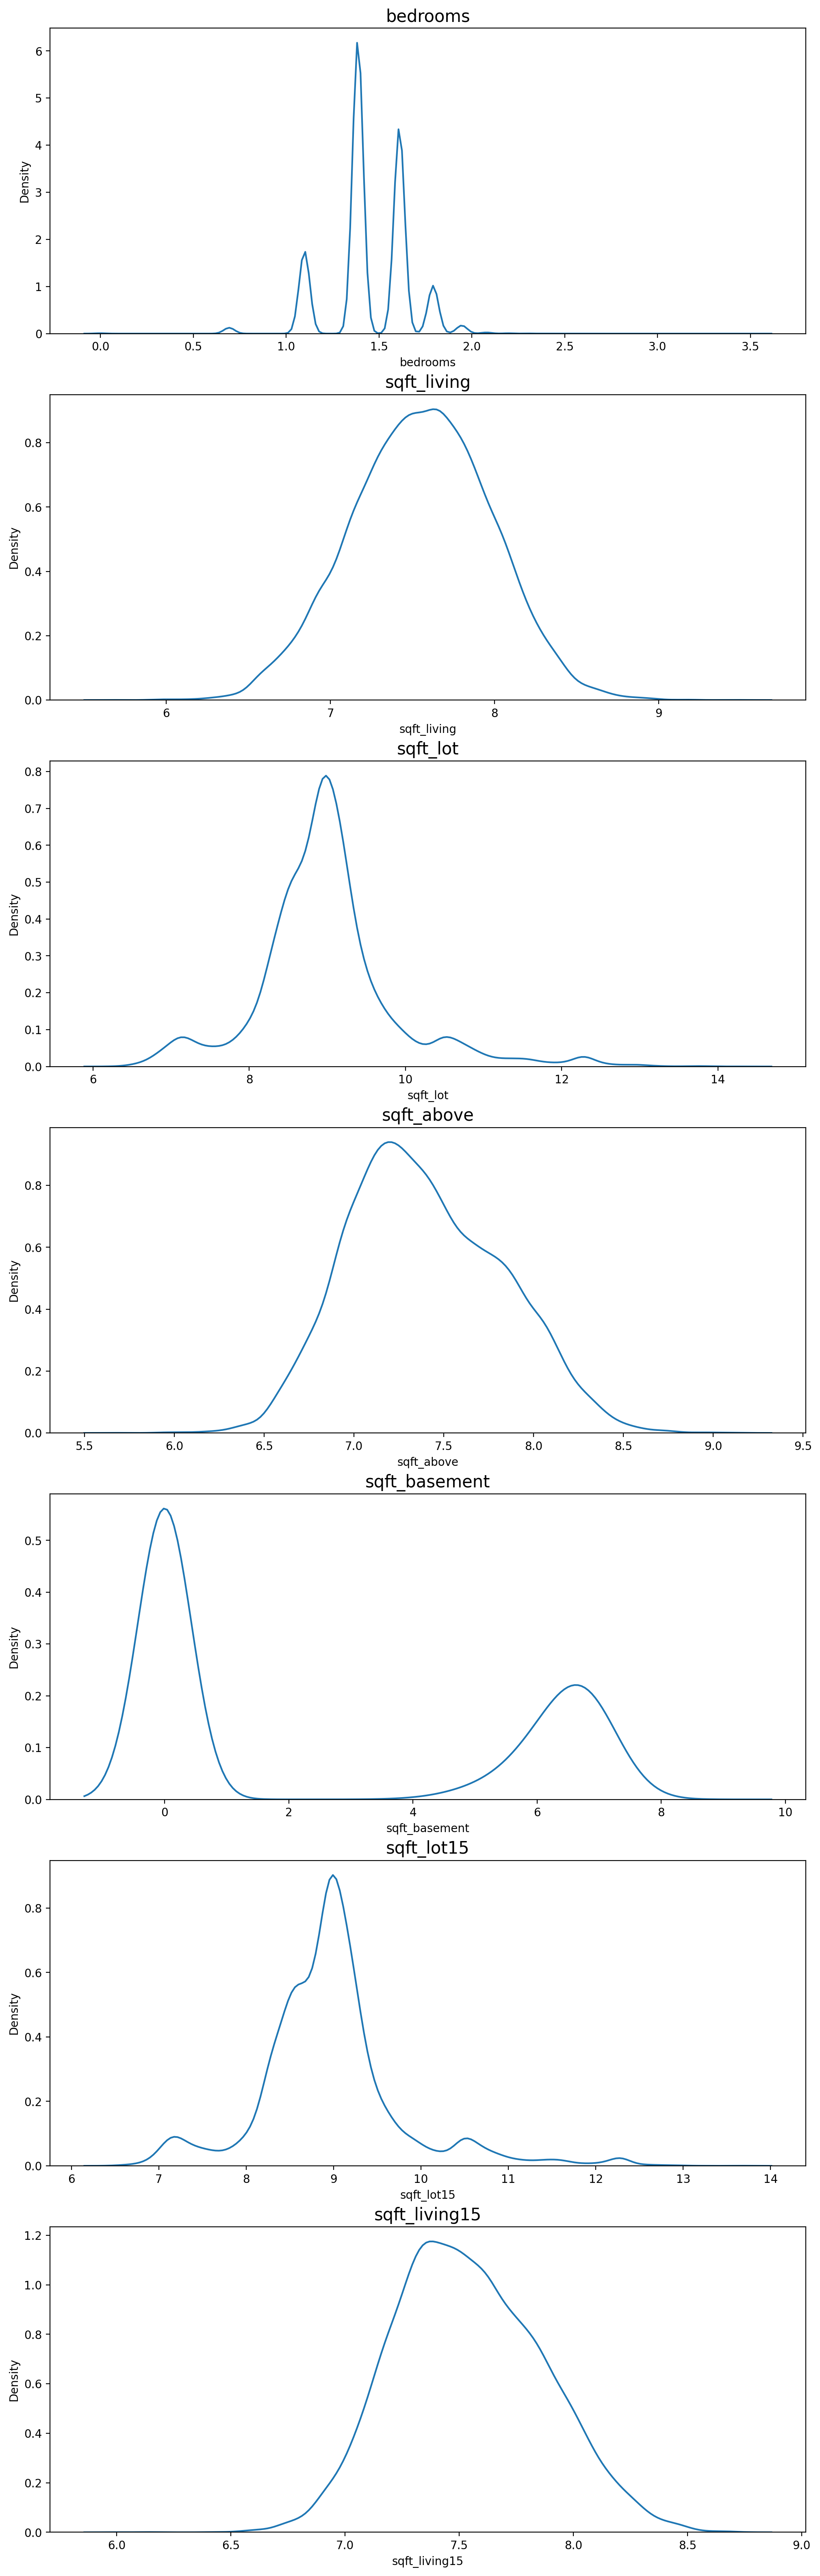

In [ ]:
fig, ax = plt.subplots(7, 1, figsize=(12, 40))


for i in range(7):
    sns.kdeplot(data=data[skew_columns[i]], ax=ax[i])
    ax[i].set_title(skew_columns[i], fontsize=15)

### 데이터 전처리 과정 추가

삭제해야하는 칼럼 : date, sqft_lot, sqft_lot15, condition  
삭제 보류 : lat, long  
zipcode 원리 : 첫 번째 숫자는 주, 두 번째 세 번째 숫자는 카운티 나머지 숫자는 배달 주소 그룹이라고 함  
1~3번째 숫자만 쓰기
xgboost에 범주형 데이터 돌리면 오류나므로 + 클래스 적기 때문에 zipcode 정수형 데이터로 처리

보수적으로 데이터를 잡으면 정확도가 올라갔다고 하신 분을 참고하여 price 500,000이상 데이터 다 삭제할 생각 -> 최대한 보류

waterfront와 view의 상관 관계로 보아 view는 집이 좋아보이는 정도가 아니라 집에서 보는 뷰를 말하는 모양이다.  
view와 waterfront도 삭제하지 않는 것으로 하겠다.

In [ ]:
# 중요하지 않은 컬럼 삭제

drop_cols = ['date', 'sqft_lot', 'condition', 'sqft_lot15']

data = data.drop(drop_cols, axis=1)
data.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  grade  \
0  1.386294       1.00     7.074117     1.0           0     0      7   
1  1.098612       1.00     6.647688     1.0           0     0      6   
2  1.386294       2.00     7.427144     1.0           0     0      8   
3  1.386294       2.25     7.447751     2.0           0     0      7   
4  1.386294       1.50     6.966967     1.0           0     0      7   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0    7.074117            0.0      1955             0    98178  47.5112   
1    6.647688            0.0      1933             0    98028  47.7379   
2    7.427144            0.0      1987             0    98074  47.6168   
3    7.447751            0.0      1995             0    98003  47.3097   
4    6.966967            0.0      1963             0    98198  47.4095   

      long  sqft_living15  
0 -122.257       7.201171  
1 -122.233       7.908755  
2 -122.045       7.496097  
3 -122.327       7.713785  
4 -122.315       7.409136

In [ ]:
# 표준화 함수
def standardize(data, columns):
    return (data[columns] - data[columns].mean()) / data[columns].std()

# 정규화 함수
def normalize(data, columns):
    return (data[columns] - data[columns].min()) / (data[columns].max() - data[columns].min())


In [ ]:
# zipcode 앞의 세자리만 남기기
data['zipcode'] = data['zipcode'] // 100

In [ ]:
# 수치화할 데이터 칼럼
numeric_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15']
categorical_columns = ['zipcode']


data = standardize(data, numeric_columns)
data = normalize(data, numeric_columns)
data.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view     grade  \
0  0.393123    0.12500     0.364775     0.0         0.0   0.0  0.500000   
1  0.311543    0.12500     0.253731     0.0         0.0   0.0  0.416667   
2  0.393123    0.25000     0.456706     0.0         0.0   0.0  0.583333   
3  0.393123    0.28125     0.462072     0.4         0.0   0.0  0.500000   
4  0.393123    0.18750     0.336873     0.0         0.0   0.0  0.500000   

   sqft_above  sqft_basement  yr_built  zipcode       lat      long  \
0    0.402954            0.0  0.478261      1.0  0.571498  0.217608   
1    0.280287            0.0  0.286957      0.0  0.936143  0.237542   
2    0.504506            0.0  0.756522      0.0  0.741354  0.393688   
3    0.510434            0.0  0.826087      0.0  0.247386  0.159468   
4    0.372131            0.0  0.547826      1.0  0.407914  0.169435   

   sqft_living15  
0       0.441078  
1       0.699074  
2       0.548613  
3       0.627985  
4       0.516906

### y 정규분포로 변환
(로그변환)

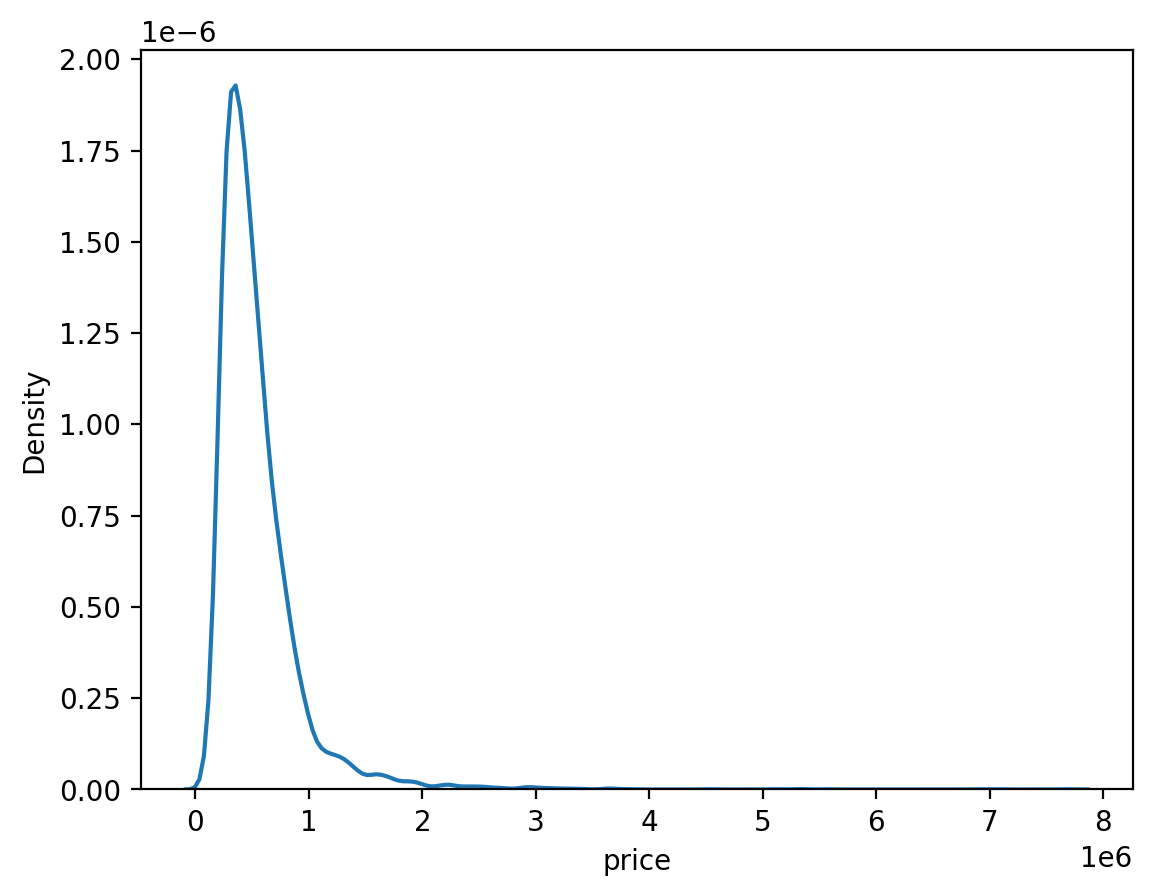

In [ ]:
# 타겟 데이터 확인

sns.kdeplot(data=y)
plt.show()

In [ ]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

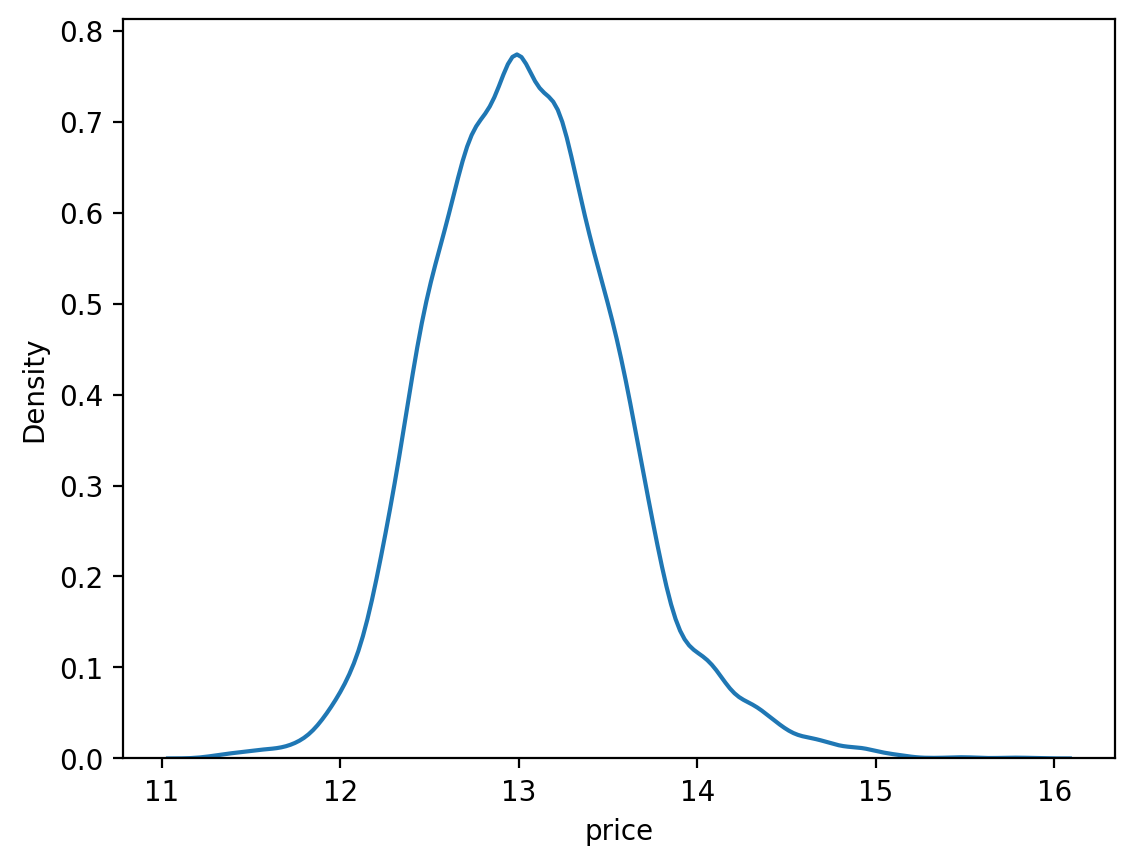

In [ ]:
sns.kdeplot(data=y)
plt.show()

### 모델 준비 및 학습

In [ ]:
X = data.iloc[:train_len]
sub = data.iloc[train_len:]


print(y.shape)
print(X.shape)
print(sub.shape)

(15035,)
(15035, 14)
(6468, 14)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# rmse 계산

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
# gboost = GradientBoostingRegressor(random_state=2019)
# xgboost = xgb.XGBRegressor(random_state=2019)
# lightgbm = lgb.LGBMRegressor(random_state=2019)

# models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#           {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
# def get_cv_score(models):
#     kfold = KFold(n_splits=5).get_n_splits(X.values)
#     for m in models:
#         CV_score = np.mean(cross_val_score(m['model'], X=X.values, y=y, cv=kfold))
#         print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [ ]:
# get_cv_score(models)

In [ ]:
# # 모델 3개 합치기

# def AveragingBlending(models, x, y, sub_x):
#     for m in models :
#         m['model'].fit(x.values, y)

#     predictions = np.column_stack([
#         m['model'].predict(sub_x.values) for m in models
#     ])
#     return np.mean(predictions, axis=1)

In [ ]:
# y_pred = AveragingBlending(models, X, y, sub)
# print(len(y_pred))
# y_pred

In [ ]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)

    # 모델 학습
        model.fit(X_train, y_train)

    # 예측
        pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, pred)

    # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return df

get_scores(models, X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 14
[LightGBM] [Info] Start training from score 13.047779


{'GradientBoostingRegressor': 132168.16497341965,
 'XGBRegressor': 123584.2599568678,
 'LGBMRegressor': 119189.73898065451,
 'RandomForestRegressor': 126876.26328413088}

### 하이퍼 파라미터 실험하기

In [ ]:
# GridSearchCV 활용

from sklearn.model_selection import GridSearchCV

In [ ]:
# """
# 다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

# 1. GridSearchCV 모델로 `model`을 초기화합니다.
# 2. 모델을 fitting 합니다.
# 3. params, score에 각 조합에 대한 결과를 저장합니다.
# 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
# """

# # 코드 입력
# def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#     # GridSearchCV 모델로 초기화
#     grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs=n_jobs)

#     # 데이터  분할 (8:2)
#     X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)

#     # 모델 fitting
#     grid_model.fit(X_train, y_train)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')

#     return results

In [ ]:
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [1, 10],
# }

# model = LGBMRegressor(random_state=random_state)
# my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

### 하이퍼 파라미터 조정 2차

In [ ]:
# # scoring NRMSE로 변경

# # 코드 입력
# def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#     # GridSearchCV 모델로 초기화
#     grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_root_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs=n_jobs)

#     # 데이터  분할 (8:2)
#     X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)

#     # 모델 fitting
#     grid_model.fit(X_train, y_train)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')

#     return results

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 5, 10],
#     'num_leaves': [20, 31, 50],
#     'feature_fraction': [0.7, 0.8, 1.0]
# }

# model = LGBMRegressor(random_state=random_state)
# my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

파라미터 설정이 중복 혹은 무시되면 오류 발생

In [ ]:
# # 파라미터 후보 줄여서 다시 시도

# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 5, 10]
# }

# model = LGBMRegressor(random_state=random_state)
# my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

시도해본 결과 NRMSE는 오히려 결과가 나쁨

In [ ]:
# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 데이터  분할 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)

    # 모델 fitting
    grid_model.fit(X_train, y_train)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
# 파라미터 후보 바꿔 다시 시도

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 6, 8, 12],
    'learning_rate': [0.01, 0.02, 0.05]
}


model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 14
[LightGBM] [Info] Start training from score 13.047779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


learning_rate  max_depth  n_estimators     score     RMSLE
58           0.05         12           400 -0.030527  0.174719
53           0.05          8           400 -0.030582  0.174877
59           0.05         12           500 -0.030611  0.174959
52           0.05          8           300 -0.030613  0.174965
57           0.05         12           300 -0.030618  0.174979
54           0.05          8           500 -0.030649  0.175069
48           0.05          6           400 -0.030672  0.175133
49           0.05          6           500 -0.030674  0.175139
39           0.02         12           500 -0.030713  0.175252
47           0.05          6           300 -0.030772  0.175420
34           0.02          8           500 -0.030791  0.175473
51           0.05          8           200 -0.030837  0.175606
56           0.05         12           200 -0.030846  0.175630
38           0.02         12           400 -0.030934  0.175881
33           0.02          8           400 -0.031011  0.176099
29           0.02          6           500 -0.031019  0.176123
46           0.05          6           200 -0.031094  0.176335
37           0.02         12           300 -0.031344  0.177043
28           0.02          6           400 -0.031349  0.177057
32           0.02          8           300 -0.031537  0.177586
19           0.01         12           500 -0.031852  0.178470
55           0.05         12           100 -0.031927  0.178680
27           0.02          6           300 -0.032028  0.178964
14           0.01          8           500 -0.032112  0.179199
50           0.05          8           100 -0.032152  0.179309
9            0.01          6           500 -0.032749  0.180967
45           0.05          6           100 -0.032805  0.181122
18           0.01         12           400 -0.033065  0.181837
36           0.02         12           200 -0.033084  0.181891
31           0.02          8           200 -0.033264  0.182383
13           0.01          8           400 -0.033280  0.182429
8            0.01          6           400 -0.033916  0.184163
26           0.02          6           200 -0.033935  0.184214
17           0.01         12           300 -0.035789  0.189180
12           0.01          8           300 -0.035876  0.189409
7            0.01          6           300 -0.036473  0.190979
44           0.05          2           500 -0.037362  0.193293
43           0.05          2           400 -0.038157  0.195338
42           0.05          2           300 -0.039325  0.198305
24           0.02          2           500 -0.041537  0.203806
41           0.05          2           200 -0.041622  0.204014
23           0.02          2           400 -0.043357  0.208225
35           0.02         12           100 -0.044495  0.210938
30           0.02          8           100 -0.044503  0.210958
16           0.01         12           200 -0.044615  0.211224
11           0.01          8           200 -0.044657  0.211321
25           0.02          6           100 -0.045189  0.212576
6            0.01          6           200 -0.045317  0.212878
22           0.02          2           300 -0.046912  0.216593
40           0.05          2           100 -0.050062  0.223745
4            0.01          2           500 -0.050245  0.224154
21           0.02          2           200 -0.055523  0.235633
3            0.01          2           400 -0.055662  0.235927
2            0.01          2           300 -0.065123  0.255193
15           0.01         12           100 -0.081255  0.285052
10           0.01          8           100 -0.081264  0.285069
5            0.01          6           100 -0.081753  0.285924
20           0.02          2           100 -0.082286  0.286855
1            0.01          2           200 -0.082506  0.287239
0            0.01          2           100 -0.123516  0.351448

In [ ]:
model = LGBMRegressor(max_depth=12, n_estimators=500, learning_rate=0.05, random_state=random_state)
model.fit(X, y)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 14
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(learning_rate=0.05, max_depth=12, n_estimators=500,
              random_state=2020)

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, X, y, sub, 'lgbm', rmsle='0.0.174719')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 14
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
/content/submission_lgbm_RMSLE_0.0.174719.csv saved!


Kaggle private score : 119834